In [1]:
import keras.callbacks
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import math
import pandas as pd
import random
from tensorflow.keras import models, layers, callbacks, activations

import librosa
import librosa.display

import warnings

import pickle

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
RUN = '1'

SAMPLE_RATE = 24000
FREQ_SIZE = 188
SECONDS = 4

N_MFCC = 100

BATCH_SIZE_TRAIN = 50
BATCH_SIZE_TEST = 1
BATCH_SIZE_VAL = 70
EPOCHS = 100

NUM_TRAIN = 500
NUM_VAL = 490
NUM_TEST = 250

STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE_TRAIN

NUM_LANGUAGES = 1

LOG_DIR = "logs/model"

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

LEARNING_RATE = 0.0001

In [3]:
BASE_DIR_HK = '../../../spectrogram/zh-HK/clips/'
TRAIN_PATH_HK = '../../../spectrogram/zh-HK/train.tsv'
TEST_PATH_HK = '../../../spectrogram/zh-HK/test.tsv'
VAL_PATH_HK = '../../../spectrogram/zh-HK/val.tsv'

MODEL_SAVE_PATH = 'savedcheckpoints'

NUM_TRAIN_HK = NUM_TRAIN
NUM_TEST_HK = NUM_TEST
NUM_VAL_HK = NUM_VAL
LABELS_HK = ['零','四','唔係','六','八','係','五','二','九','三','七','一']
NUM_LABELS_HK = len(LABELS_HK)

In [4]:
def padaudio(waveform):
    if (len(waveform) >= SAMPLE_RATE * SECONDS):
        return waveform
    else:
        return np.pad(waveform,(0,SAMPLE_RATE * SECONDS - len(waveform)),mode='constant', constant_values=(0,0))

def processdata(file):
    filename = '../../..' + file.split(".")[-2] + '.pkl'
    with open(filename,'rb') as f:
        spectrogram = pickle.load(f)
    return spectrogram

In [5]:
def getlabel(onehot,labels):
    index = np.argmax(onehot)
    label = labels[index]
    return label

def getonehot(label,labels):
    onehot = np.array([1 if x == label else 0 for x in labels])
    return onehot

In [6]:
def getdata(df,base_dir):
    df['fullpath'] = base_dir + df['path']
    inputs = df['fullpath'].tolist()
    labels = df['sentence'].tolist()
    x = np.array(inputs)
    y = np.array(labels)
    return x,y

In [7]:
dftrainHK = pd.read_csv(TRAIN_PATH_HK, sep='\t', header=0)
dftrainHK.sort_values(by='length',ascending=False,inplace=True)
trainxHK,trainyHK, = getdata(dftrainHK.head(NUM_TRAIN_HK), BASE_DIR_HK)

dfvalHK = pd.read_csv(VAL_PATH_HK, sep='\t', header=0)
dfvalHK.sort_values(by='length',ascending=False,inplace=True)
valxHK,valyHK, = getdata(dfvalHK.head(NUM_VAL_HK), BASE_DIR_HK)

dftestHK = pd.read_csv(TEST_PATH_HK, sep='\t', header=0)
dftestHK.sort_values(by='length',ascending=False,inplace=True)
testxHK,testyHK, = getdata(dftestHK.head(NUM_TEST_HK), BASE_DIR_HK)

C:\Users\aning\AppData\Local\Temp/ipykernel_26284/954889505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fullpath'] = base_dir + df['path']


In [8]:
def maketraingenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(trainxHK)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator


xtypes = tuple([tf.float32]*NUM_LANGUAGES)
ytypes = tuple([tf.int32]*NUM_LANGUAGES)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(NUM_LANGUAGES)])
yshapes = tuple([[12]])
traingenshapes = (xshapes,yshapes)

In [9]:
def makevalgenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(valxHK)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator

In [10]:
trainxs = [trainxHK]
trainys = [[trainyHK,LABELS_HK]]

valxs = [valxHK]
valys = [[valyHK,LABELS_HK]]

In [11]:
def maketestgenerator(testx,testy,labels):
    def testgenerator():
        for i in range(len(testx)):
            x = processdata(testx[i])
            y = getonehot(testy[i],labels)
            yield x,y
    return testgenerator

testgentypes = (tf.float32,tf.int32)
testgenshapes = ([FREQ_SIZE,N_MFCC,1],[12])

In [12]:
traindataset = tf.data.Dataset.from_generator(maketraingenerator(trainxs,trainys),output_types=traingentypes,output_shapes=traingenshapes)
traindataset = traindataset.shuffle(NUM_TRAIN_HK)
traindataset = traindataset.batch(BATCH_SIZE_TRAIN)
traindataset = traindataset.repeat(-1)
traindataset = traindataset.cache().prefetch(AUTOTUNE)

valdataset = tf.data.Dataset.from_generator(makevalgenerator(valxs,valys),output_types=traingentypes,output_shapes=traingenshapes)
valdataset = valdataset.batch(BATCH_SIZE_VAL)
valdataset = valdataset.cache().prefetch(AUTOTUNE)

testdatasetHK = tf.data.Dataset.from_generator(maketestgenerator(testxHK,testyHK,LABELS_HK),output_types=testgentypes,output_shapes=testgenshapes)
testdatasetHK = testdatasetHK.batch(BATCH_SIZE_TEST)

In [13]:
modelpath1 = '../model1/savedmodels/model11-shared'
modelpath2 = '../model2/savedmodels/model27-Shared'
modelpath3 = '../model3/savedmodels/model32-Shared'
modelpath4 = '../model4/savedmodels/model41-Shared'
modelpath5 = '../model5/savedmodels/model52-Shared'

In [14]:
def languagelayers(num_labels,language):
        lang = keras.Sequential([
        layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D1'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D1'),
        # layers.Conv2D(filters=512, kernel_size=(2,2), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D2'),
        # layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D2'),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer1'),
        layers.Dropout(0.2),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer2'),
        layers.Dropout(0.2),
        layers.Dense(num_labels, activation=activations.softmax, name=language+'_Output')
        ],
        name=language)

        return lang

In [37]:
shared1 = keras.models.load_model(modelpath1)
shared2 = keras.models.load_model(modelpath2)
shared3 = keras.models.load_model(modelpath3)
shared4 = keras.models.load_model(modelpath4)
shared5 = keras.models.load_model(modelpath5)

Model: "Full_Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_1 (InputLayer)        [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                               

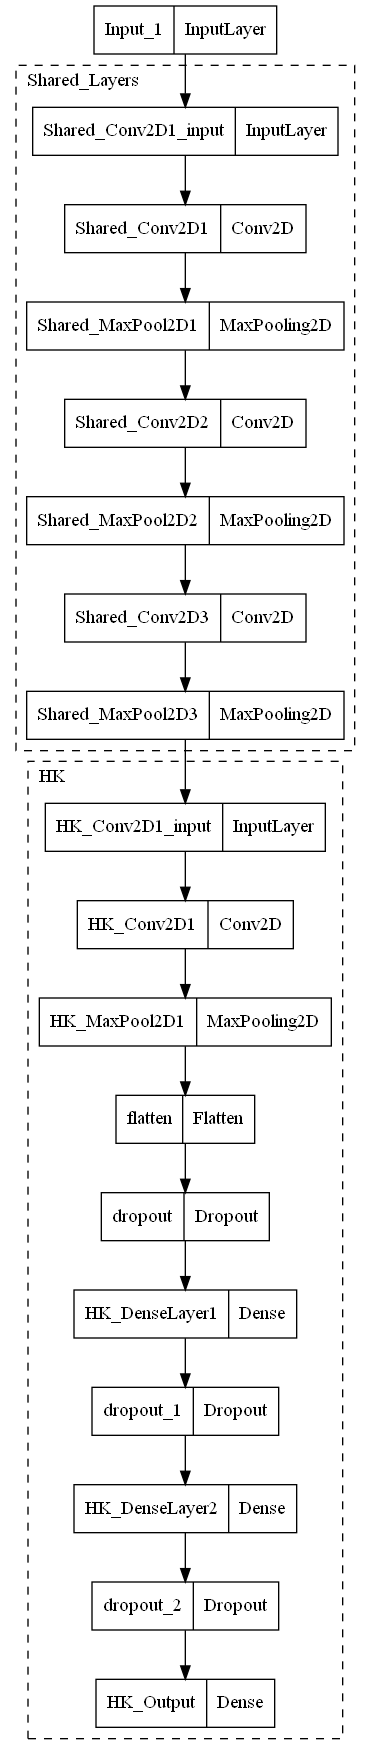

In [16]:
input1 = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='Input_1')

shared1.trainable = False
sharedLayers1 = shared1(input1)
individualLayers1 = languagelayers(NUM_LABELS_HK,'HK')(sharedLayers1)

model1 = tf.keras.Model(
    inputs=[input1],
    outputs=[individualLayers1],
    name='Full_Model_1'
)

model1.summary(expand_nested=True)
tf.keras.utils.plot_model(model1, expand_nested=True)

In [17]:
model1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [18]:
training_callback1 = callbacks.TensorBoard(log_dir=LOG_DIR + '1')
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint1 = callbacks.ModelCheckpoint(
    filepath=MODEL_SAVE_PATH + '1',
    save_weights_only=False,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [19]:
history1 = model1.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback1,earlystopping_callback,reduce_lr_callback,checkpoint1],
    verbose=1
)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 2.5478 - Categorical_Accuracy: 0.1100 - AUC: 0.5072 

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 5s 449ms/step - loss: 2.5478 - Categorical_Accuracy: 0.1100 - AUC: 0.5072 - val_loss: 2.4613 - val_Categorical_Accuracy: 0.1265 - val_AUC: 0.5669 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 2.4651 - Categorical_Accuracy: 0.1380 - AUC: 0.5619

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 302ms/step - loss: 2.4651 - Categorical_Accuracy: 0.1380 - AUC: 0.5619 - val_loss: 2.4211 - val_Categorical_Accuracy: 0.1694 - val_AUC: 0.6499 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 2.4256 - Categorical_Accuracy: 0.1380 - AUC: 0.6102

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 337ms/step - loss: 2.4256 - Categorical_Accuracy: 0.1380 - AUC: 0.6102 - val_loss: 2.3837 - val_Categorical_Accuracy: 0.2000 - val_AUC: 0.7024 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 2.3766 - Categorical_Accuracy: 0.1760 - AUC: 0.6600

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 318ms/step - loss: 2.3766 - Categorical_Accuracy: 0.1760 - AUC: 0.6600 - val_loss: 2.3388 - val_Categorical_Accuracy: 0.2224 - val_AUC: 0.7484 - lr: 1.0000e-04
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 2.3410 - Categorical_Accuracy: 0.2160 - AUC: 0.6766

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 293ms/step - loss: 2.3410 - Categorical_Accuracy: 0.2160 - AUC: 0.6766 - val_loss: 2.2932 - val_Categorical_Accuracy: 0.2551 - val_AUC: 0.7597 - lr: 1.0000e-04
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 2.2950 - Categorical_Accuracy: 0.2280 - AUC: 0.7140

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 323ms/step - loss: 2.2950 - Categorical_Accuracy: 0.2280 - AUC: 0.7140 - val_loss: 2.2450 - val_Categorical_Accuracy: 0.2959 - val_AUC: 0.7944 - lr: 1.0000e-04
Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 2.2390 - Categorical_Accuracy: 0.2320 - AUC: 0.7448

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 307ms/step - loss: 2.2390 - Categorical_Accuracy: 0.2320 - AUC: 0.7448 - val_loss: 2.1939 - val_Categorical_Accuracy: 0.3204 - val_AUC: 0.8098 - lr: 1.0000e-04
Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 2.1761 - Categorical_Accuracy: 0.2720 - AUC: 0.7734

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 375ms/step - loss: 2.1761 - Categorical_Accuracy: 0.2720 - AUC: 0.7734 - val_loss: 2.1346 - val_Categorical_Accuracy: 0.3469 - val_AUC: 0.8205 - lr: 1.0000e-04
Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 2.1454 - Categorical_Accuracy: 0.2580 - AUC: 0.7735

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 332ms/step - loss: 2.1454 - Categorical_Accuracy: 0.2580 - AUC: 0.7735 - val_loss: 2.0797 - val_Categorical_Accuracy: 0.3184 - val_AUC: 0.8261 - lr: 1.0000e-04
Epoch 10/100
10/10 [==============================] - ETA: 0s - loss: 2.0640 - Categorical_Accuracy: 0.3180 - AUC: 0.8003

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 324ms/step - loss: 2.0640 - Categorical_Accuracy: 0.3180 - AUC: 0.8003 - val_loss: 2.0205 - val_Categorical_Accuracy: 0.4000 - val_AUC: 0.8404 - lr: 1.0000e-04
Epoch 11/100
10/10 [==============================] - ETA: 0s - loss: 2.0387 - Categorical_Accuracy: 0.2980 - AUC: 0.8066

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 351ms/step - loss: 2.0387 - Categorical_Accuracy: 0.2980 - AUC: 0.8066 - val_loss: 1.9610 - val_Categorical_Accuracy: 0.4286 - val_AUC: 0.8539 - lr: 1.0000e-04
Epoch 12/100
10/10 [==============================] - ETA: 0s - loss: 1.9599 - Categorical_Accuracy: 0.3280 - AUC: 0.8327

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 346ms/step - loss: 1.9599 - Categorical_Accuracy: 0.3280 - AUC: 0.8327 - val_loss: 1.9089 - val_Categorical_Accuracy: 0.4408 - val_AUC: 0.8618 - lr: 1.0000e-04
Epoch 13/100
10/10 [==============================] - ETA: 0s - loss: 1.8871 - Categorical_Accuracy: 0.3740 - AUC: 0.8439

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 308ms/step - loss: 1.8871 - Categorical_Accuracy: 0.3740 - AUC: 0.8439 - val_loss: 1.8496 - val_Categorical_Accuracy: 0.4735 - val_AUC: 0.8729 - lr: 1.0000e-04
Epoch 14/100
10/10 [==============================] - ETA: 0s - loss: 1.8676 - Categorical_Accuracy: 0.3740 - AUC: 0.8472

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 293ms/step - loss: 1.8676 - Categorical_Accuracy: 0.3740 - AUC: 0.8472 - val_loss: 1.8001 - val_Categorical_Accuracy: 0.4959 - val_AUC: 0.8813 - lr: 1.0000e-04
Epoch 15/100
10/10 [==============================] - ETA: 0s - loss: 1.7623 - Categorical_Accuracy: 0.4180 - AUC: 0.8778

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 318ms/step - loss: 1.7623 - Categorical_Accuracy: 0.4180 - AUC: 0.8778 - val_loss: 1.7546 - val_Categorical_Accuracy: 0.5000 - val_AUC: 0.8853 - lr: 1.0000e-04
Epoch 16/100
10/10 [==============================] - ETA: 0s - loss: 1.7161 - Categorical_Accuracy: 0.4420 - AUC: 0.8790

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 291ms/step - loss: 1.7161 - Categorical_Accuracy: 0.4420 - AUC: 0.8790 - val_loss: 1.7132 - val_Categorical_Accuracy: 0.4857 - val_AUC: 0.8860 - lr: 1.0000e-04
Epoch 17/100
10/10 [==============================] - ETA: 0s - loss: 1.7079 - Categorical_Accuracy: 0.4340 - AUC: 0.8758

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 300ms/step - loss: 1.7079 - Categorical_Accuracy: 0.4340 - AUC: 0.8758 - val_loss: 1.6641 - val_Categorical_Accuracy: 0.5245 - val_AUC: 0.8978 - lr: 1.0000e-04
Epoch 18/100
10/10 [==============================] - ETA: 0s - loss: 1.6433 - Categorical_Accuracy: 0.4420 - AUC: 0.8951

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 291ms/step - loss: 1.6433 - Categorical_Accuracy: 0.4420 - AUC: 0.8951 - val_loss: 1.6202 - val_Categorical_Accuracy: 0.5531 - val_AUC: 0.9030 - lr: 1.0000e-04
Epoch 19/100
10/10 [==============================] - ETA: 0s - loss: 1.5822 - Categorical_Accuracy: 0.4680 - AUC: 0.9041

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 282ms/step - loss: 1.5822 - Categorical_Accuracy: 0.4680 - AUC: 0.9041 - val_loss: 1.5683 - val_Categorical_Accuracy: 0.5816 - val_AUC: 0.9130 - lr: 1.0000e-04
Epoch 20/100
10/10 [==============================] - ETA: 0s - loss: 1.5025 - Categorical_Accuracy: 0.5320 - AUC: 0.9149

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 310ms/step - loss: 1.5025 - Categorical_Accuracy: 0.5320 - AUC: 0.9149 - val_loss: 1.5201 - val_Categorical_Accuracy: 0.5939 - val_AUC: 0.9176 - lr: 1.0000e-04
Epoch 21/100
10/10 [==============================] - ETA: 0s - loss: 1.4810 - Categorical_Accuracy: 0.5220 - AUC: 0.9150

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 320ms/step - loss: 1.4810 - Categorical_Accuracy: 0.5220 - AUC: 0.9150 - val_loss: 1.4893 - val_Categorical_Accuracy: 0.5816 - val_AUC: 0.9176 - lr: 1.0000e-04
Epoch 22/100
10/10 [==============================] - ETA: 0s - loss: 1.4169 - Categorical_Accuracy: 0.5460 - AUC: 0.9219

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 309ms/step - loss: 1.4169 - Categorical_Accuracy: 0.5460 - AUC: 0.9219 - val_loss: 1.4469 - val_Categorical_Accuracy: 0.5918 - val_AUC: 0.9234 - lr: 1.0000e-04
Epoch 23/100
10/10 [==============================] - ETA: 0s - loss: 1.3965 - Categorical_Accuracy: 0.5880 - AUC: 0.9260

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 313ms/step - loss: 1.3965 - Categorical_Accuracy: 0.5880 - AUC: 0.9260 - val_loss: 1.4091 - val_Categorical_Accuracy: 0.6224 - val_AUC: 0.9265 - lr: 1.0000e-04
Epoch 24/100
10/10 [==============================] - ETA: 0s - loss: 1.3553 - Categorical_Accuracy: 0.5620 - AUC: 0.9294

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 293ms/step - loss: 1.3553 - Categorical_Accuracy: 0.5620 - AUC: 0.9294 - val_loss: 1.3722 - val_Categorical_Accuracy: 0.6224 - val_AUC: 0.9330 - lr: 1.0000e-04
Epoch 25/100
10/10 [==============================] - ETA: 0s - loss: 1.3046 - Categorical_Accuracy: 0.5880 - AUC: 0.9373

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 335ms/step - loss: 1.3046 - Categorical_Accuracy: 0.5880 - AUC: 0.9373 - val_loss: 1.3366 - val_Categorical_Accuracy: 0.6265 - val_AUC: 0.9351 - lr: 1.0000e-04
Epoch 26/100
10/10 [==============================] - ETA: 0s - loss: 1.2362 - Categorical_Accuracy: 0.6200 - AUC: 0.9464

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 343ms/step - loss: 1.2362 - Categorical_Accuracy: 0.6200 - AUC: 0.9464 - val_loss: 1.3046 - val_Categorical_Accuracy: 0.6163 - val_AUC: 0.9370 - lr: 1.0000e-04
Epoch 27/100
10/10 [==============================] - ETA: 0s - loss: 1.1987 - Categorical_Accuracy: 0.6140 - AUC: 0.9476

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 296ms/step - loss: 1.1987 - Categorical_Accuracy: 0.6140 - AUC: 0.9476 - val_loss: 1.2761 - val_Categorical_Accuracy: 0.6347 - val_AUC: 0.9393 - lr: 1.0000e-04
Epoch 28/100
10/10 [==============================] - ETA: 0s - loss: 1.1600 - Categorical_Accuracy: 0.6180 - AUC: 0.9515

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 360ms/step - loss: 1.1600 - Categorical_Accuracy: 0.6180 - AUC: 0.9515 - val_loss: 1.2453 - val_Categorical_Accuracy: 0.6531 - val_AUC: 0.9434 - lr: 1.0000e-04
Epoch 29/100
10/10 [==============================] - ETA: 0s - loss: 1.1464 - Categorical_Accuracy: 0.6460 - AUC: 0.9507

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 295ms/step - loss: 1.1464 - Categorical_Accuracy: 0.6460 - AUC: 0.9507 - val_loss: 1.2215 - val_Categorical_Accuracy: 0.6510 - val_AUC: 0.9446 - lr: 1.0000e-04
Epoch 30/100
10/10 [==============================] - ETA: 0s - loss: 1.0996 - Categorical_Accuracy: 0.6560 - AUC: 0.9569

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 300ms/step - loss: 1.0996 - Categorical_Accuracy: 0.6560 - AUC: 0.9569 - val_loss: 1.1970 - val_Categorical_Accuracy: 0.6633 - val_AUC: 0.9466 - lr: 1.0000e-04
Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 1.0220 - Categorical_Accuracy: 0.6980 - AUC: 0.9635

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 349ms/step - loss: 1.0220 - Categorical_Accuracy: 0.6980 - AUC: 0.9635 - val_loss: 1.1613 - val_Categorical_Accuracy: 0.6694 - val_AUC: 0.9491 - lr: 1.0000e-04
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 1.0428 - Categorical_Accuracy: 0.6760 - AUC: 0.9613

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 295ms/step - loss: 1.0428 - Categorical_Accuracy: 0.6760 - AUC: 0.9613 - val_loss: 1.1464 - val_Categorical_Accuracy: 0.6755 - val_AUC: 0.9502 - lr: 1.0000e-04
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 0.9943 - Categorical_Accuracy: 0.6900 - AUC: 0.9641

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 302ms/step - loss: 0.9943 - Categorical_Accuracy: 0.6900 - AUC: 0.9641 - val_loss: 1.1261 - val_Categorical_Accuracy: 0.6776 - val_AUC: 0.9504 - lr: 1.0000e-04
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.9317 - Categorical_Accuracy: 0.7260 - AUC: 0.9694

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 314ms/step - loss: 0.9317 - Categorical_Accuracy: 0.7260 - AUC: 0.9694 - val_loss: 1.1065 - val_Categorical_Accuracy: 0.6633 - val_AUC: 0.9519 - lr: 1.0000e-04
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.9702 - Categorical_Accuracy: 0.7080 - AUC: 0.9662

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 294ms/step - loss: 0.9702 - Categorical_Accuracy: 0.7080 - AUC: 0.9662 - val_loss: 1.0902 - val_Categorical_Accuracy: 0.6633 - val_AUC: 0.9528 - lr: 1.0000e-04
Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 0.9088 - Categorical_Accuracy: 0.7140 - AUC: 0.9725

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 295ms/step - loss: 0.9088 - Categorical_Accuracy: 0.7140 - AUC: 0.9725 - val_loss: 1.0639 - val_Categorical_Accuracy: 0.6755 - val_AUC: 0.9560 - lr: 1.0000e-04
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.9206 - Categorical_Accuracy: 0.6900 - AUC: 0.9692

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 319ms/step - loss: 0.9206 - Categorical_Accuracy: 0.6900 - AUC: 0.9692 - val_loss: 1.0446 - val_Categorical_Accuracy: 0.6918 - val_AUC: 0.9570 - lr: 1.0000e-04
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.8487 - Categorical_Accuracy: 0.7360 - AUC: 0.9768

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 297ms/step - loss: 0.8487 - Categorical_Accuracy: 0.7360 - AUC: 0.9768 - val_loss: 1.0394 - val_Categorical_Accuracy: 0.6898 - val_AUC: 0.9562 - lr: 1.0000e-04
Epoch 39/100
10/10 [==============================] - ETA: 0s - loss: 0.8224 - Categorical_Accuracy: 0.7560 - AUC: 0.9766

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 325ms/step - loss: 0.8224 - Categorical_Accuracy: 0.7560 - AUC: 0.9766 - val_loss: 1.0169 - val_Categorical_Accuracy: 0.6816 - val_AUC: 0.9580 - lr: 1.0000e-04
Epoch 40/100
10/10 [==============================] - ETA: 0s - loss: 0.8214 - Categorical_Accuracy: 0.7380 - AUC: 0.9764

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 306ms/step - loss: 0.8214 - Categorical_Accuracy: 0.7380 - AUC: 0.9764 - val_loss: 0.9968 - val_Categorical_Accuracy: 0.7122 - val_AUC: 0.9595 - lr: 1.0000e-04
Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 0.7953 - Categorical_Accuracy: 0.7480 - AUC: 0.9783

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 293ms/step - loss: 0.7953 - Categorical_Accuracy: 0.7480 - AUC: 0.9783 - val_loss: 0.9853 - val_Categorical_Accuracy: 0.6939 - val_AUC: 0.9596 - lr: 1.0000e-04
Epoch 42/100
10/10 [==============================] - ETA: 0s - loss: 0.7063 - Categorical_Accuracy: 0.7900 - AUC: 0.9835

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 336ms/step - loss: 0.7063 - Categorical_Accuracy: 0.7900 - AUC: 0.9835 - val_loss: 0.9684 - val_Categorical_Accuracy: 0.7286 - val_AUC: 0.9614 - lr: 1.0000e-04
Epoch 43/100
10/10 [==============================] - ETA: 0s - loss: 0.7398 - Categorical_Accuracy: 0.7580 - AUC: 0.9810

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 325ms/step - loss: 0.7398 - Categorical_Accuracy: 0.7580 - AUC: 0.9810 - val_loss: 0.9545 - val_Categorical_Accuracy: 0.7163 - val_AUC: 0.9623 - lr: 1.0000e-04
Epoch 44/100
10/10 [==============================] - ETA: 0s - loss: 0.6942 - Categorical_Accuracy: 0.7960 - AUC: 0.9846

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 311ms/step - loss: 0.6942 - Categorical_Accuracy: 0.7960 - AUC: 0.9846 - val_loss: 0.9462 - val_Categorical_Accuracy: 0.7041 - val_AUC: 0.9624 - lr: 1.0000e-04
Epoch 45/100
10/10 [==============================] - ETA: 0s - loss: 0.6781 - Categorical_Accuracy: 0.8220 - AUC: 0.9852

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 317ms/step - loss: 0.6781 - Categorical_Accuracy: 0.8220 - AUC: 0.9852 - val_loss: 0.9371 - val_Categorical_Accuracy: 0.7306 - val_AUC: 0.9632 - lr: 1.0000e-04
Epoch 46/100
10/10 [==============================] - ETA: 0s - loss: 0.6594 - Categorical_Accuracy: 0.7960 - AUC: 0.9868

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 294ms/step - loss: 0.6594 - Categorical_Accuracy: 0.7960 - AUC: 0.9868 - val_loss: 0.9311 - val_Categorical_Accuracy: 0.7020 - val_AUC: 0.9632 - lr: 1.0000e-04
Epoch 47/100
10/10 [==============================] - ETA: 0s - loss: 0.6516 - Categorical_Accuracy: 0.7980 - AUC: 0.9860

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 328ms/step - loss: 0.6516 - Categorical_Accuracy: 0.7980 - AUC: 0.9860 - val_loss: 0.9145 - val_Categorical_Accuracy: 0.7245 - val_AUC: 0.9650 - lr: 1.0000e-04
Epoch 48/100
10/10 [==============================] - ETA: 0s - loss: 0.6162 - Categorical_Accuracy: 0.8120 - AUC: 0.9878

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 328ms/step - loss: 0.6162 - Categorical_Accuracy: 0.8120 - AUC: 0.9878 - val_loss: 0.9012 - val_Categorical_Accuracy: 0.7327 - val_AUC: 0.9660 - lr: 1.0000e-04
Epoch 49/100
10/10 [==============================] - ETA: 0s - loss: 0.6485 - Categorical_Accuracy: 0.7820 - AUC: 0.9848

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 305ms/step - loss: 0.6485 - Categorical_Accuracy: 0.7820 - AUC: 0.9848 - val_loss: 0.9003 - val_Categorical_Accuracy: 0.7245 - val_AUC: 0.9648 - lr: 1.0000e-04
Epoch 50/100
10/10 [==============================] - ETA: 0s - loss: 0.5777 - Categorical_Accuracy: 0.8260 - AUC: 0.9893

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 335ms/step - loss: 0.5777 - Categorical_Accuracy: 0.8260 - AUC: 0.9893 - val_loss: 0.8796 - val_Categorical_Accuracy: 0.7388 - val_AUC: 0.9668 - lr: 1.0000e-04
Epoch 51/100
10/10 [==============================] - ETA: 0s - loss: 0.6335 - Categorical_Accuracy: 0.8060 - AUC: 0.9845

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 325ms/step - loss: 0.5728 - Categorical_Accuracy: 0.8340 - AUC: 0.9898 - val_loss: 0.8719 - val_Categorical_Accuracy: 0.7367 - val_AUC: 0.9670 - lr: 1.0000e-04
Epoch 53/100
10/10 [==============================] - ETA: 0s - loss: 0.5530 - Categorical_Accuracy: 0.8320 - AUC: 0.9913

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 298ms/step - loss: 0.5530 - Categorical_Accuracy: 0.8320 - AUC: 0.9913 - val_loss: 0.8590 - val_Categorical_Accuracy: 0.7469 - val_AUC: 0.9672 - lr: 1.0000e-04
Epoch 54/100
10/10 [==============================] - ETA: 0s - loss: 0.5577 - Categorical_Accuracy: 0.8220 - AUC: 0.9899

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 325ms/step - loss: 0.5577 - Categorical_Accuracy: 0.8220 - AUC: 0.9899 - val_loss: 0.8533 - val_Categorical_Accuracy: 0.7469 - val_AUC: 0.9669 - lr: 1.0000e-04
Epoch 55/100
10/10 [==============================] - ETA: 0s - loss: 0.5133 - Categorical_Accuracy: 0.8700 - AUC: 0.9918

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 314ms/step - loss: 0.5133 - Categorical_Accuracy: 0.8700 - AUC: 0.9918 - val_loss: 0.8483 - val_Categorical_Accuracy: 0.7327 - val_AUC: 0.9683 - lr: 1.0000e-04
Epoch 56/100
10/10 [==============================] - ETA: 0s - loss: 0.5054 - Categorical_Accuracy: 0.8480 - AUC: 0.9925

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 305ms/step - loss: 0.5054 - Categorical_Accuracy: 0.8480 - AUC: 0.9925 - val_loss: 0.8345 - val_Categorical_Accuracy: 0.7408 - val_AUC: 0.9693 - lr: 1.0000e-04
Epoch 57/100
10/10 [==============================] - ETA: 0s - loss: 0.4672 - Categorical_Accuracy: 0.8680 - AUC: 0.9944

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 337ms/step - loss: 0.5206 - Categorical_Accuracy: 0.8300 - AUC: 0.9910 - val_loss: 0.8243 - val_Categorical_Accuracy: 0.7510 - val_AUC: 0.9692 - lr: 1.0000e-04
Epoch 59/100
10/10 [==============================] - ETA: 0s - loss: 0.4586 - Categorical_Accuracy: 0.8760 - AUC: 0.9942

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 303ms/step - loss: 0.4562 - Categorical_Accuracy: 0.8700 - AUC: 0.9936 - val_loss: 0.8035 - val_Categorical_Accuracy: 0.7531 - val_AUC: 0.9711 - lr: 1.0000e-04
Epoch 61/100
10/10 [==============================] - ETA: 0s - loss: 0.4300 - Categorical_Accuracy: 0.8880 - AUC: 0.9950

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 337ms/step - loss: 0.4564 - Categorical_Accuracy: 0.8580 - AUC: 0.9939 - val_loss: 0.8018 - val_Categorical_Accuracy: 0.7490 - val_AUC: 0.9695 - lr: 1.0000e-04
Epoch 63/100
10/10 [==============================] - ETA: 0s - loss: 0.3975 - Categorical_Accuracy: 0.9040 - AUC: 0.9962

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 318ms/step - loss: 0.3975 - Categorical_Accuracy: 0.9040 - AUC: 0.9962 - val_loss: 0.7894 - val_Categorical_Accuracy: 0.7510 - val_AUC: 0.9706 - lr: 1.0000e-04
Epoch 64/100
10/10 [==============================] - ETA: 0s - loss: 0.4318 - Categorical_Accuracy: 0.8680 - AUC: 0.9940

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 296ms/step - loss: 0.3934 - Categorical_Accuracy: 0.8900 - AUC: 0.9956 - val_loss: 0.7770 - val_Categorical_Accuracy: 0.7551 - val_AUC: 0.9713 - lr: 1.0000e-04
Epoch 66/100
10/10 [==============================] - ETA: 0s - loss: 0.3888 - Categorical_Accuracy: 0.8900 - AUC: 0.9960

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 332ms/step - loss: 0.3571 - Categorical_Accuracy: 0.9020 - AUC: 0.9965 - val_loss: 0.7749 - val_Categorical_Accuracy: 0.7551 - val_AUC: 0.9708 - lr: 1.0000e-05
Epoch 71/100
10/10 [==============================] - ETA: 0s - loss: 0.3789 - Categorical_Accuracy: 0.8880 - AUC: 0.9957

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 288ms/step - loss: 0.3789 - Categorical_Accuracy: 0.8880 - AUC: 0.9957 - val_loss: 0.7705 - val_Categorical_Accuracy: 0.7551 - val_AUC: 0.9710 - lr: 1.0000e-05
Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 0.3592 - Categorical_Accuracy: 0.9160 - AUC: 0.9965

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 281ms/step - loss: 0.3592 - Categorical_Accuracy: 0.9160 - AUC: 0.9965 - val_loss: 0.7679 - val_Categorical_Accuracy: 0.7612 - val_AUC: 0.9712 - lr: 1.0000e-05
Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 0.3652 - Categorical_Accuracy: 0.9080 - AUC: 0.9964

INFO:tensorflow:Assets written to: savedcheckpoints1\assets


INFO:tensorflow:Assets written to: savedcheckpoints1\assets


10/10 [==============================] - 3s 339ms/step - loss: 0.3652 - Categorical_Accuracy: 0.9080 - AUC: 0.9964 - val_loss: 0.7674 - val_Categorical_Accuracy: 0.7633 - val_AUC: 0.9712 - lr: 1.0000e-05
Epoch 74/100
10/10 [==============================] - ETA: 0s - loss: 0.3883 - Categorical_Accuracy: 0.8760 - AUC: 0.9952

In [20]:
model1c = keras.models.load_model('savedcheckpoints1')
model1c.evaluate(testdatasetHK)

250/250 [==============================] - 2s 6ms/step - loss: 0.9184 - Categorical_Accuracy: 0.7160 - AUC: 0.9589

[0.9183506369590759, 0.7160000205039978, 0.9589192867279053]

Model: "Full_Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_2 (InputLayer)        [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                               

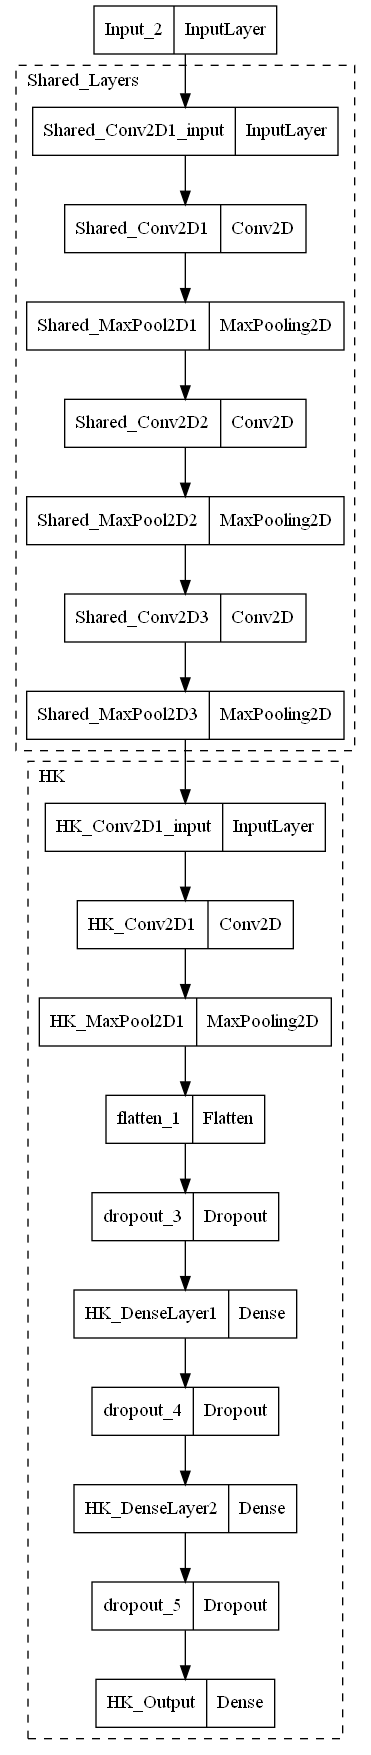

In [21]:
input2 = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='Input_2')

shared2.trainable = False
sharedLayers2 = shared2(input2)
individualLayers2 = languagelayers(NUM_LABELS_HK,'HK')(sharedLayers2)

model2 = tf.keras.Model(
    inputs=[input2],
    outputs=[individualLayers2],
    name='Full_Model_2'
)

model2.summary(expand_nested=True)
tf.keras.utils.plot_model(model2, expand_nested=True)


In [22]:
model2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)


In [23]:
training_callback2 = callbacks.TensorBoard(log_dir=LOG_DIR + '2')
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint2 = callbacks.ModelCheckpoint(
    filepath=MODEL_SAVE_PATH + '2',
    save_weights_only=False,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [24]:
history2 = model2.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback2,earlystopping_callback,reduce_lr_callback,checkpoint2],
    verbose=1
)


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 2.5488 - Categorical_Accuracy: 0.0840 - AUC: 0.5215

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 294ms/step - loss: 2.5488 - Categorical_Accuracy: 0.0840 - AUC: 0.5215 - val_loss: 2.4457 - val_Categorical_Accuracy: 0.1265 - val_AUC: 0.5860 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 2.4489 - Categorical_Accuracy: 0.1220 - AUC: 0.5814

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 308ms/step - loss: 2.4489 - Categorical_Accuracy: 0.1220 - AUC: 0.5814 - val_loss: 2.3864 - val_Categorical_Accuracy: 0.2102 - val_AUC: 0.6866 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 2.3925 - Categorical_Accuracy: 0.1680 - AUC: 0.6259

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 289ms/step - loss: 2.3925 - Categorical_Accuracy: 0.1680 - AUC: 0.6259 - val_loss: 2.3364 - val_Categorical_Accuracy: 0.2694 - val_AUC: 0.7335 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 2.3367 - Categorical_Accuracy: 0.1800 - AUC: 0.6788

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 325ms/step - loss: 2.3367 - Categorical_Accuracy: 0.1800 - AUC: 0.6788 - val_loss: 2.2821 - val_Categorical_Accuracy: 0.3082 - val_AUC: 0.7657 - lr: 1.0000e-04
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 2.2775 - Categorical_Accuracy: 0.2340 - AUC: 0.7101

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 296ms/step - loss: 2.2775 - Categorical_Accuracy: 0.2340 - AUC: 0.7101 - val_loss: 2.2168 - val_Categorical_Accuracy: 0.3347 - val_AUC: 0.7908 - lr: 1.0000e-04
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 2.1999 - Categorical_Accuracy: 0.2620 - AUC: 0.7517

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 301ms/step - loss: 2.1999 - Categorical_Accuracy: 0.2620 - AUC: 0.7517 - val_loss: 2.1523 - val_Categorical_Accuracy: 0.3633 - val_AUC: 0.8105 - lr: 1.0000e-04
Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 2.1422 - Categorical_Accuracy: 0.3080 - AUC: 0.7718

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 351ms/step - loss: 2.1422 - Categorical_Accuracy: 0.3080 - AUC: 0.7718 - val_loss: 2.0900 - val_Categorical_Accuracy: 0.3776 - val_AUC: 0.8238 - lr: 1.0000e-04
Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 2.1030 - Categorical_Accuracy: 0.2880 - AUC: 0.7759

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 321ms/step - loss: 2.1030 - Categorical_Accuracy: 0.2880 - AUC: 0.7759 - val_loss: 2.0318 - val_Categorical_Accuracy: 0.3755 - val_AUC: 0.8344 - lr: 1.0000e-04
Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 1.9879 - Categorical_Accuracy: 0.3480 - AUC: 0.8231

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 316ms/step - loss: 1.9879 - Categorical_Accuracy: 0.3480 - AUC: 0.8231 - val_loss: 1.9634 - val_Categorical_Accuracy: 0.4143 - val_AUC: 0.8607 - lr: 1.0000e-04
Epoch 10/100
10/10 [==============================] - ETA: 0s - loss: 1.9636 - Categorical_Accuracy: 0.3640 - AUC: 0.8205

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 314ms/step - loss: 1.9636 - Categorical_Accuracy: 0.3640 - AUC: 0.8205 - val_loss: 1.8964 - val_Categorical_Accuracy: 0.4367 - val_AUC: 0.8773 - lr: 1.0000e-04
Epoch 11/100
10/10 [==============================] - ETA: 0s - loss: 1.8907 - Categorical_Accuracy: 0.3780 - AUC: 0.8406

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 347ms/step - loss: 1.8907 - Categorical_Accuracy: 0.3780 - AUC: 0.8406 - val_loss: 1.8337 - val_Categorical_Accuracy: 0.4612 - val_AUC: 0.8887 - lr: 1.0000e-04
Epoch 12/100
10/10 [==============================] - ETA: 0s - loss: 1.8341 - Categorical_Accuracy: 0.3820 - AUC: 0.8591

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 336ms/step - loss: 1.8341 - Categorical_Accuracy: 0.3820 - AUC: 0.8591 - val_loss: 1.7676 - val_Categorical_Accuracy: 0.4571 - val_AUC: 0.8911 - lr: 1.0000e-04
Epoch 13/100
10/10 [==============================] - ETA: 0s - loss: 1.7255 - Categorical_Accuracy: 0.4440 - AUC: 0.8767

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 332ms/step - loss: 1.7255 - Categorical_Accuracy: 0.4440 - AUC: 0.8767 - val_loss: 1.7063 - val_Categorical_Accuracy: 0.4857 - val_AUC: 0.9061 - lr: 1.0000e-04
Epoch 14/100
10/10 [==============================] - ETA: 0s - loss: 1.6795 - Categorical_Accuracy: 0.4400 - AUC: 0.8876

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 329ms/step - loss: 1.6795 - Categorical_Accuracy: 0.4400 - AUC: 0.8876 - val_loss: 1.6456 - val_Categorical_Accuracy: 0.5082 - val_AUC: 0.9122 - lr: 1.0000e-04
Epoch 15/100
10/10 [==============================] - ETA: 0s - loss: 1.6297 - Categorical_Accuracy: 0.4820 - AUC: 0.8954

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 346ms/step - loss: 1.6297 - Categorical_Accuracy: 0.4820 - AUC: 0.8954 - val_loss: 1.5833 - val_Categorical_Accuracy: 0.5306 - val_AUC: 0.9198 - lr: 1.0000e-04
Epoch 16/100
10/10 [==============================] - ETA: 0s - loss: 1.5816 - Categorical_Accuracy: 0.5040 - AUC: 0.8985

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 349ms/step - loss: 1.5816 - Categorical_Accuracy: 0.5040 - AUC: 0.8985 - val_loss: 1.5253 - val_Categorical_Accuracy: 0.5571 - val_AUC: 0.9251 - lr: 1.0000e-04
Epoch 17/100
10/10 [==============================] - ETA: 0s - loss: 1.5001 - Categorical_Accuracy: 0.4980 - AUC: 0.9105

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 311ms/step - loss: 1.5001 - Categorical_Accuracy: 0.4980 - AUC: 0.9105 - val_loss: 1.4676 - val_Categorical_Accuracy: 0.5735 - val_AUC: 0.9305 - lr: 1.0000e-04
Epoch 18/100
10/10 [==============================] - ETA: 0s - loss: 1.4293 - Categorical_Accuracy: 0.5420 - AUC: 0.9235

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 301ms/step - loss: 1.4293 - Categorical_Accuracy: 0.5420 - AUC: 0.9235 - val_loss: 1.4226 - val_Categorical_Accuracy: 0.5918 - val_AUC: 0.9330 - lr: 1.0000e-04
Epoch 19/100
10/10 [==============================] - ETA: 0s - loss: 1.3391 - Categorical_Accuracy: 0.5740 - AUC: 0.9369

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 327ms/step - loss: 1.3391 - Categorical_Accuracy: 0.5740 - AUC: 0.9369 - val_loss: 1.3661 - val_Categorical_Accuracy: 0.6163 - val_AUC: 0.9396 - lr: 1.0000e-04
Epoch 20/100
10/10 [==============================] - ETA: 0s - loss: 1.3239 - Categorical_Accuracy: 0.5480 - AUC: 0.9376

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 310ms/step - loss: 1.3239 - Categorical_Accuracy: 0.5480 - AUC: 0.9376 - val_loss: 1.3114 - val_Categorical_Accuracy: 0.6469 - val_AUC: 0.9426 - lr: 1.0000e-04
Epoch 21/100
10/10 [==============================] - ETA: 0s - loss: 1.2602 - Categorical_Accuracy: 0.5860 - AUC: 0.9400

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 285ms/step - loss: 1.2602 - Categorical_Accuracy: 0.5860 - AUC: 0.9400 - val_loss: 1.2707 - val_Categorical_Accuracy: 0.6490 - val_AUC: 0.9449 - lr: 1.0000e-04
Epoch 22/100
10/10 [==============================] - ETA: 0s - loss: 1.2745 - Categorical_Accuracy: 0.5680 - AUC: 0.9378

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 307ms/step - loss: 1.2745 - Categorical_Accuracy: 0.5680 - AUC: 0.9378 - val_loss: 1.2318 - val_Categorical_Accuracy: 0.6510 - val_AUC: 0.9491 - lr: 1.0000e-04
Epoch 23/100
10/10 [==============================] - ETA: 0s - loss: 1.2433 - Categorical_Accuracy: 0.6020 - AUC: 0.9396

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 4s 407ms/step - loss: 1.2433 - Categorical_Accuracy: 0.6020 - AUC: 0.9396 - val_loss: 1.2025 - val_Categorical_Accuracy: 0.6796 - val_AUC: 0.9504 - lr: 1.0000e-04
Epoch 24/100
10/10 [==============================] - ETA: 0s - loss: 1.1825 - Categorical_Accuracy: 0.6160 - AUC: 0.9501

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 317ms/step - loss: 1.1825 - Categorical_Accuracy: 0.6160 - AUC: 0.9501 - val_loss: 1.1630 - val_Categorical_Accuracy: 0.6837 - val_AUC: 0.9538 - lr: 1.0000e-04
Epoch 25/100
10/10 [==============================] - ETA: 0s - loss: 1.0804 - Categorical_Accuracy: 0.7020 - AUC: 0.9597

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 347ms/step - loss: 1.0804 - Categorical_Accuracy: 0.7020 - AUC: 0.9597 - val_loss: 1.1280 - val_Categorical_Accuracy: 0.7000 - val_AUC: 0.9560 - lr: 1.0000e-04
Epoch 26/100
10/10 [==============================] - ETA: 0s - loss: 1.0528 - Categorical_Accuracy: 0.6820 - AUC: 0.9608

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 351ms/step - loss: 1.0528 - Categorical_Accuracy: 0.6820 - AUC: 0.9608 - val_loss: 1.1120 - val_Categorical_Accuracy: 0.6959 - val_AUC: 0.9566 - lr: 1.0000e-04
Epoch 27/100
10/10 [==============================] - ETA: 0s - loss: 1.0188 - Categorical_Accuracy: 0.6880 - AUC: 0.9637

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 310ms/step - loss: 1.0188 - Categorical_Accuracy: 0.6880 - AUC: 0.9637 - val_loss: 1.0673 - val_Categorical_Accuracy: 0.7041 - val_AUC: 0.9595 - lr: 1.0000e-04
Epoch 28/100
10/10 [==============================] - ETA: 0s - loss: 1.0666 - Categorical_Accuracy: 0.6400 - AUC: 0.9575

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 344ms/step - loss: 1.0666 - Categorical_Accuracy: 0.6400 - AUC: 0.9575 - val_loss: 1.0385 - val_Categorical_Accuracy: 0.7245 - val_AUC: 0.9613 - lr: 1.0000e-04
Epoch 29/100
10/10 [==============================] - ETA: 0s - loss: 0.9576 - Categorical_Accuracy: 0.7180 - AUC: 0.9677

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 315ms/step - loss: 0.9576 - Categorical_Accuracy: 0.7180 - AUC: 0.9677 - val_loss: 1.0233 - val_Categorical_Accuracy: 0.7143 - val_AUC: 0.9617 - lr: 1.0000e-04
Epoch 30/100
10/10 [==============================] - ETA: 0s - loss: 0.8803 - Categorical_Accuracy: 0.7280 - AUC: 0.9755

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 4s 405ms/step - loss: 0.8803 - Categorical_Accuracy: 0.7280 - AUC: 0.9755 - val_loss: 0.9939 - val_Categorical_Accuracy: 0.7265 - val_AUC: 0.9640 - lr: 1.0000e-04
Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 0.8794 - Categorical_Accuracy: 0.7080 - AUC: 0.9735

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 326ms/step - loss: 0.8794 - Categorical_Accuracy: 0.7080 - AUC: 0.9735 - val_loss: 0.9755 - val_Categorical_Accuracy: 0.7286 - val_AUC: 0.9644 - lr: 1.0000e-04
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 0.8473 - Categorical_Accuracy: 0.7500 - AUC: 0.9754

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 340ms/step - loss: 0.8473 - Categorical_Accuracy: 0.7500 - AUC: 0.9754 - val_loss: 0.9525 - val_Categorical_Accuracy: 0.7367 - val_AUC: 0.9661 - lr: 1.0000e-04
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 0.8631 - Categorical_Accuracy: 0.7340 - AUC: 0.9733

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 325ms/step - loss: 0.8631 - Categorical_Accuracy: 0.7340 - AUC: 0.9733 - val_loss: 0.9352 - val_Categorical_Accuracy: 0.7286 - val_AUC: 0.9665 - lr: 1.0000e-04
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.8151 - Categorical_Accuracy: 0.7460 - AUC: 0.9759

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 4s 397ms/step - loss: 0.8151 - Categorical_Accuracy: 0.7460 - AUC: 0.9759 - val_loss: 0.9165 - val_Categorical_Accuracy: 0.7367 - val_AUC: 0.9678 - lr: 1.0000e-04
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.8018 - Categorical_Accuracy: 0.7460 - AUC: 0.9768

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 356ms/step - loss: 0.8018 - Categorical_Accuracy: 0.7460 - AUC: 0.9768 - val_loss: 0.9146 - val_Categorical_Accuracy: 0.7571 - val_AUC: 0.9672 - lr: 1.0000e-04
Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 0.7186 - Categorical_Accuracy: 0.7820 - AUC: 0.9832

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 335ms/step - loss: 0.7186 - Categorical_Accuracy: 0.7820 - AUC: 0.9832 - val_loss: 0.8905 - val_Categorical_Accuracy: 0.7265 - val_AUC: 0.9683 - lr: 1.0000e-04
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.7171 - Categorical_Accuracy: 0.7660 - AUC: 0.9836

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 373ms/step - loss: 0.7171 - Categorical_Accuracy: 0.7660 - AUC: 0.9836 - val_loss: 0.8844 - val_Categorical_Accuracy: 0.7367 - val_AUC: 0.9690 - lr: 1.0000e-04
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.7029 - Categorical_Accuracy: 0.7900 - AUC: 0.9823

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 360ms/step - loss: 0.7029 - Categorical_Accuracy: 0.7900 - AUC: 0.9823 - val_loss: 0.8633 - val_Categorical_Accuracy: 0.7347 - val_AUC: 0.9699 - lr: 1.0000e-04
Epoch 39/100
10/10 [==============================] - ETA: 0s - loss: 0.6636 - Categorical_Accuracy: 0.8160 - AUC: 0.9854

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 359ms/step - loss: 0.6636 - Categorical_Accuracy: 0.8160 - AUC: 0.9854 - val_loss: 0.8430 - val_Categorical_Accuracy: 0.7571 - val_AUC: 0.9713 - lr: 1.0000e-04
Epoch 40/100
10/10 [==============================] - ETA: 0s - loss: 0.6620 - Categorical_Accuracy: 0.7980 - AUC: 0.9852

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 359ms/step - loss: 0.6620 - Categorical_Accuracy: 0.7980 - AUC: 0.9852 - val_loss: 0.8337 - val_Categorical_Accuracy: 0.7510 - val_AUC: 0.9721 - lr: 1.0000e-04
Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 0.6287 - Categorical_Accuracy: 0.8180 - AUC: 0.9872

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 344ms/step - loss: 0.6287 - Categorical_Accuracy: 0.8180 - AUC: 0.9872 - val_loss: 0.8260 - val_Categorical_Accuracy: 0.7429 - val_AUC: 0.9721 - lr: 1.0000e-04
Epoch 42/100
10/10 [==============================] - ETA: 0s - loss: 0.6369 - Categorical_Accuracy: 0.7880 - AUC: 0.9867

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 311ms/step - loss: 0.6369 - Categorical_Accuracy: 0.7880 - AUC: 0.9867 - val_loss: 0.8211 - val_Categorical_Accuracy: 0.7592 - val_AUC: 0.9722 - lr: 1.0000e-04
Epoch 43/100
10/10 [==============================] - ETA: 0s - loss: 0.5686 - Categorical_Accuracy: 0.8360 - AUC: 0.9894

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 333ms/step - loss: 0.5686 - Categorical_Accuracy: 0.8360 - AUC: 0.9894 - val_loss: 0.8085 - val_Categorical_Accuracy: 0.7633 - val_AUC: 0.9732 - lr: 1.0000e-04
Epoch 44/100
10/10 [==============================] - ETA: 0s - loss: 0.5864 - Categorical_Accuracy: 0.8240 - AUC: 0.9879

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 346ms/step - loss: 0.5864 - Categorical_Accuracy: 0.8240 - AUC: 0.9879 - val_loss: 0.7929 - val_Categorical_Accuracy: 0.7571 - val_AUC: 0.9736 - lr: 1.0000e-04
Epoch 45/100
10/10 [==============================] - ETA: 0s - loss: 0.5795 - Categorical_Accuracy: 0.8180 - AUC: 0.9880

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 337ms/step - loss: 0.5795 - Categorical_Accuracy: 0.8180 - AUC: 0.9880 - val_loss: 0.7841 - val_Categorical_Accuracy: 0.7571 - val_AUC: 0.9744 - lr: 1.0000e-04
Epoch 46/100
10/10 [==============================] - ETA: 0s - loss: 0.5658 - Categorical_Accuracy: 0.8340 - AUC: 0.9887

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 381ms/step - loss: 0.5658 - Categorical_Accuracy: 0.8340 - AUC: 0.9887 - val_loss: 0.7824 - val_Categorical_Accuracy: 0.7469 - val_AUC: 0.9743 - lr: 1.0000e-04
Epoch 47/100
10/10 [==============================] - ETA: 0s - loss: 0.5358 - Categorical_Accuracy: 0.8440 - AUC: 0.9907

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 320ms/step - loss: 0.5358 - Categorical_Accuracy: 0.8440 - AUC: 0.9907 - val_loss: 0.7770 - val_Categorical_Accuracy: 0.7776 - val_AUC: 0.9746 - lr: 1.0000e-04
Epoch 48/100
10/10 [==============================] - ETA: 0s - loss: 0.5339 - Categorical_Accuracy: 0.8380 - AUC: 0.9905

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 327ms/step - loss: 0.5339 - Categorical_Accuracy: 0.8380 - AUC: 0.9905 - val_loss: 0.7766 - val_Categorical_Accuracy: 0.7551 - val_AUC: 0.9740 - lr: 1.0000e-04
Epoch 49/100
10/10 [==============================] - ETA: 0s - loss: 0.5714 - Categorical_Accuracy: 0.8360 - AUC: 0.9875

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 358ms/step - loss: 0.5714 - Categorical_Accuracy: 0.8360 - AUC: 0.9875 - val_loss: 0.7628 - val_Categorical_Accuracy: 0.7633 - val_AUC: 0.9753 - lr: 1.0000e-04
Epoch 50/100
10/10 [==============================] - ETA: 0s - loss: 0.4914 - Categorical_Accuracy: 0.8820 - AUC: 0.9918

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 320ms/step - loss: 0.4914 - Categorical_Accuracy: 0.8820 - AUC: 0.9918 - val_loss: 0.7484 - val_Categorical_Accuracy: 0.7694 - val_AUC: 0.9766 - lr: 1.0000e-04
Epoch 51/100
10/10 [==============================] - ETA: 0s - loss: 0.4729 - Categorical_Accuracy: 0.8780 - AUC: 0.9930

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 365ms/step - loss: 0.4729 - Categorical_Accuracy: 0.8780 - AUC: 0.9930 - val_loss: 0.7421 - val_Categorical_Accuracy: 0.7878 - val_AUC: 0.9765 - lr: 1.0000e-04
Epoch 52/100
10/10 [==============================] - ETA: 0s - loss: 0.4873 - Categorical_Accuracy: 0.8520 - AUC: 0.9922

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 4s 381ms/step - loss: 0.5033 - Categorical_Accuracy: 0.8460 - AUC: 0.9908 - val_loss: 0.7385 - val_Categorical_Accuracy: 0.7776 - val_AUC: 0.9762 - lr: 1.0000e-04
Epoch 54/100
10/10 [==============================] - ETA: 0s - loss: 0.4484 - Categorical_Accuracy: 0.8660 - AUC: 0.9937

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 4s 389ms/step - loss: 0.4484 - Categorical_Accuracy: 0.8660 - AUC: 0.9937 - val_loss: 0.7289 - val_Categorical_Accuracy: 0.7633 - val_AUC: 0.9771 - lr: 1.0000e-04
Epoch 55/100
10/10 [==============================] - ETA: 0s - loss: 0.4149 - Categorical_Accuracy: 0.8860 - AUC: 0.9953

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 355ms/step - loss: 0.4149 - Categorical_Accuracy: 0.8860 - AUC: 0.9953 - val_loss: 0.7180 - val_Categorical_Accuracy: 0.7755 - val_AUC: 0.9773 - lr: 1.0000e-04
Epoch 56/100
10/10 [==============================] - ETA: 0s - loss: 0.4214 - Categorical_Accuracy: 0.8820 - AUC: 0.9942

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 349ms/step - loss: 0.3802 - Categorical_Accuracy: 0.9120 - AUC: 0.9964 - val_loss: 0.7179 - val_Categorical_Accuracy: 0.7673 - val_AUC: 0.9771 - lr: 2.0000e-05
Epoch 59/100
10/10 [==============================] - ETA: 0s - loss: 0.4028 - Categorical_Accuracy: 0.8880 - AUC: 0.9955

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 309ms/step - loss: 0.4028 - Categorical_Accuracy: 0.8880 - AUC: 0.9955 - val_loss: 0.7133 - val_Categorical_Accuracy: 0.7776 - val_AUC: 0.9775 - lr: 2.0000e-05
Epoch 60/100
10/10 [==============================] - ETA: 0s - loss: 0.3897 - Categorical_Accuracy: 0.9040 - AUC: 0.9956

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 298ms/step - loss: 0.3897 - Categorical_Accuracy: 0.9040 - AUC: 0.9956 - val_loss: 0.7115 - val_Categorical_Accuracy: 0.7776 - val_AUC: 0.9774 - lr: 2.0000e-05
Epoch 61/100
10/10 [==============================] - ETA: 0s - loss: 0.3862 - Categorical_Accuracy: 0.8860 - AUC: 0.9959

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 312ms/step - loss: 0.3862 - Categorical_Accuracy: 0.8860 - AUC: 0.9959 - val_loss: 0.7099 - val_Categorical_Accuracy: 0.7714 - val_AUC: 0.9776 - lr: 2.0000e-05
Epoch 62/100
10/10 [==============================] - ETA: 0s - loss: 0.3897 - Categorical_Accuracy: 0.8900 - AUC: 0.9955

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 356ms/step - loss: 0.3897 - Categorical_Accuracy: 0.8900 - AUC: 0.9955 - val_loss: 0.7087 - val_Categorical_Accuracy: 0.7714 - val_AUC: 0.9775 - lr: 2.0000e-05
Epoch 63/100
10/10 [==============================] - ETA: 0s - loss: 0.3832 - Categorical_Accuracy: 0.9000 - AUC: 0.9958

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 335ms/step - loss: 0.3832 - Categorical_Accuracy: 0.9000 - AUC: 0.9958 - val_loss: 0.7083 - val_Categorical_Accuracy: 0.7796 - val_AUC: 0.9777 - lr: 2.0000e-05
Epoch 64/100
10/10 [==============================] - ETA: 0s - loss: 0.3898 - Categorical_Accuracy: 0.8920 - AUC: 0.9948

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 382ms/step - loss: 0.3898 - Categorical_Accuracy: 0.8920 - AUC: 0.9948 - val_loss: 0.7068 - val_Categorical_Accuracy: 0.7776 - val_AUC: 0.9778 - lr: 2.0000e-05
Epoch 65/100
10/10 [==============================] - ETA: 0s - loss: 0.3678 - Categorical_Accuracy: 0.9020 - AUC: 0.9961

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 4s 394ms/step - loss: 0.3544 - Categorical_Accuracy: 0.9120 - AUC: 0.9969 - val_loss: 0.7066 - val_Categorical_Accuracy: 0.7796 - val_AUC: 0.9777 - lr: 1.0000e-05
Epoch 69/100
10/10 [==============================] - ETA: 0s - loss: 0.3601 - Categorical_Accuracy: 0.9020 - AUC: 0.9965

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 355ms/step - loss: 0.3601 - Categorical_Accuracy: 0.9020 - AUC: 0.9965 - val_loss: 0.7045 - val_Categorical_Accuracy: 0.7755 - val_AUC: 0.9779 - lr: 1.0000e-05
Epoch 70/100
10/10 [==============================] - ETA: 0s - loss: 0.3506 - Categorical_Accuracy: 0.9080 - AUC: 0.9965

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 4s 387ms/step - loss: 0.3506 - Categorical_Accuracy: 0.9080 - AUC: 0.9965 - val_loss: 0.7033 - val_Categorical_Accuracy: 0.7755 - val_AUC: 0.9781 - lr: 1.0000e-05
Epoch 71/100
10/10 [==============================] - ETA: 0s - loss: 0.3533 - Categorical_Accuracy: 0.9120 - AUC: 0.9965

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 358ms/step - loss: 0.3533 - Categorical_Accuracy: 0.9120 - AUC: 0.9965 - val_loss: 0.7029 - val_Categorical_Accuracy: 0.7776 - val_AUC: 0.9780 - lr: 1.0000e-05
Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 0.3506 - Categorical_Accuracy: 0.9040 - AUC: 0.9967

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 326ms/step - loss: 0.3506 - Categorical_Accuracy: 0.9040 - AUC: 0.9967 - val_loss: 0.7023 - val_Categorical_Accuracy: 0.7796 - val_AUC: 0.9780 - lr: 1.0000e-05
Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 0.3500 - Categorical_Accuracy: 0.9020 - AUC: 0.9963

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 359ms/step - loss: 0.3500 - Categorical_Accuracy: 0.9020 - AUC: 0.9963 - val_loss: 0.7019 - val_Categorical_Accuracy: 0.7837 - val_AUC: 0.9780 - lr: 1.0000e-05
Epoch 74/100
10/10 [==============================] - ETA: 0s - loss: 0.3375 - Categorical_Accuracy: 0.9100 - AUC: 0.9970

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 345ms/step - loss: 0.3687 - Categorical_Accuracy: 0.9060 - AUC: 0.9959 - val_loss: 0.7016 - val_Categorical_Accuracy: 0.7796 - val_AUC: 0.9781 - lr: 1.0000e-05
Epoch 76/100
10/10 [==============================] - ETA: 0s - loss: 0.3694 - Categorical_Accuracy: 0.8940 - AUC: 0.9958

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 338ms/step - loss: 0.3694 - Categorical_Accuracy: 0.8940 - AUC: 0.9958 - val_loss: 0.7012 - val_Categorical_Accuracy: 0.7857 - val_AUC: 0.9781 - lr: 1.0000e-05
Epoch 77/100
10/10 [==============================] - ETA: 0s - loss: 0.3812 - Categorical_Accuracy: 0.9080 - AUC: 0.9959

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 4s 417ms/step - loss: 0.3595 - Categorical_Accuracy: 0.8900 - AUC: 0.9963 - val_loss: 0.7007 - val_Categorical_Accuracy: 0.7694 - val_AUC: 0.9780 - lr: 1.0000e-05
Epoch 79/100
10/10 [==============================] - ETA: 0s - loss: 0.3638 - Categorical_Accuracy: 0.9000 - AUC: 0.9959

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 353ms/step - loss: 0.3638 - Categorical_Accuracy: 0.9000 - AUC: 0.9959 - val_loss: 0.6990 - val_Categorical_Accuracy: 0.7755 - val_AUC: 0.9782 - lr: 1.0000e-05
Epoch 80/100
10/10 [==============================] - ETA: 0s - loss: 0.3631 - Categorical_Accuracy: 0.8980 - AUC: 0.9961

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 335ms/step - loss: 0.3631 - Categorical_Accuracy: 0.8980 - AUC: 0.9961 - val_loss: 0.6976 - val_Categorical_Accuracy: 0.7755 - val_AUC: 0.9783 - lr: 1.0000e-05
Epoch 81/100
10/10 [==============================] - ETA: 0s - loss: 0.3762 - Categorical_Accuracy: 0.9040 - AUC: 0.9955

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 346ms/step - loss: 0.3762 - Categorical_Accuracy: 0.9040 - AUC: 0.9955 - val_loss: 0.6972 - val_Categorical_Accuracy: 0.7816 - val_AUC: 0.9783 - lr: 1.0000e-05
Epoch 82/100
10/10 [==============================] - ETA: 0s - loss: 0.3627 - Categorical_Accuracy: 0.9060 - AUC: 0.9961

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 304ms/step - loss: 0.3339 - Categorical_Accuracy: 0.9060 - AUC: 0.9966 - val_loss: 0.6972 - val_Categorical_Accuracy: 0.7796 - val_AUC: 0.9782 - lr: 1.0000e-05
Epoch 85/100
10/10 [==============================] - ETA: 0s - loss: 0.3537 - Categorical_Accuracy: 0.9020 - AUC: 0.9964

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 304ms/step - loss: 0.3339 - Categorical_Accuracy: 0.9160 - AUC: 0.9969 - val_loss: 0.6970 - val_Categorical_Accuracy: 0.7816 - val_AUC: 0.9783 - lr: 1.0000e-05
Epoch 88/100
10/10 [==============================] - ETA: 0s - loss: 0.3357 - Categorical_Accuracy: 0.9200 - AUC: 0.9973

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 341ms/step - loss: 0.3357 - Categorical_Accuracy: 0.9200 - AUC: 0.9973 - val_loss: 0.6967 - val_Categorical_Accuracy: 0.7837 - val_AUC: 0.9783 - lr: 1.0000e-05
Epoch 89/100
10/10 [==============================] - ETA: 0s - loss: 0.3689 - Categorical_Accuracy: 0.8920 - AUC: 0.9954

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 359ms/step - loss: 0.3689 - Categorical_Accuracy: 0.8920 - AUC: 0.9954 - val_loss: 0.6966 - val_Categorical_Accuracy: 0.7837 - val_AUC: 0.9782 - lr: 1.0000e-05
Epoch 90/100
10/10 [==============================] - ETA: 0s - loss: 0.3617 - Categorical_Accuracy: 0.8880 - AUC: 0.9962

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 379ms/step - loss: 0.3617 - Categorical_Accuracy: 0.8880 - AUC: 0.9962 - val_loss: 0.6960 - val_Categorical_Accuracy: 0.7776 - val_AUC: 0.9783 - lr: 1.0000e-05
Epoch 91/100
10/10 [==============================] - ETA: 0s - loss: 0.3437 - Categorical_Accuracy: 0.8980 - AUC: 0.9966

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 327ms/step - loss: 0.3437 - Categorical_Accuracy: 0.8980 - AUC: 0.9966 - val_loss: 0.6951 - val_Categorical_Accuracy: 0.7816 - val_AUC: 0.9783 - lr: 1.0000e-05
Epoch 92/100
10/10 [==============================] - ETA: 0s - loss: 0.3526 - Categorical_Accuracy: 0.9180 - AUC: 0.9961

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 345ms/step - loss: 0.3526 - Categorical_Accuracy: 0.9180 - AUC: 0.9961 - val_loss: 0.6939 - val_Categorical_Accuracy: 0.7776 - val_AUC: 0.9784 - lr: 1.0000e-05
Epoch 93/100
10/10 [==============================] - ETA: 0s - loss: 0.3582 - Categorical_Accuracy: 0.8940 - AUC: 0.9961

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 323ms/step - loss: 0.3582 - Categorical_Accuracy: 0.8940 - AUC: 0.9961 - val_loss: 0.6928 - val_Categorical_Accuracy: 0.7776 - val_AUC: 0.9785 - lr: 1.0000e-05
Epoch 94/100
10/10 [==============================] - ETA: 0s - loss: 0.3186 - Categorical_Accuracy: 0.9220 - AUC: 0.9975

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 330ms/step - loss: 0.3186 - Categorical_Accuracy: 0.9220 - AUC: 0.9975 - val_loss: 0.6920 - val_Categorical_Accuracy: 0.7776 - val_AUC: 0.9784 - lr: 1.0000e-05
Epoch 95/100
10/10 [==============================] - ETA: 0s - loss: 0.3568 - Categorical_Accuracy: 0.8900 - AUC: 0.9960

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 305ms/step - loss: 0.3568 - Categorical_Accuracy: 0.8900 - AUC: 0.9960 - val_loss: 0.6915 - val_Categorical_Accuracy: 0.7776 - val_AUC: 0.9784 - lr: 1.0000e-05
Epoch 96/100
10/10 [==============================] - ETA: 0s - loss: 0.3502 - Categorical_Accuracy: 0.9040 - AUC: 0.9967

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 332ms/step - loss: 0.3502 - Categorical_Accuracy: 0.9040 - AUC: 0.9967 - val_loss: 0.6908 - val_Categorical_Accuracy: 0.7796 - val_AUC: 0.9785 - lr: 1.0000e-05
Epoch 97/100
10/10 [==============================] - ETA: 0s - loss: 0.3600 - Categorical_Accuracy: 0.8980 - AUC: 0.9965

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 4s 425ms/step - loss: 0.3600 - Categorical_Accuracy: 0.8980 - AUC: 0.9965 - val_loss: 0.6904 - val_Categorical_Accuracy: 0.7796 - val_AUC: 0.9785 - lr: 1.0000e-05
Epoch 98/100
10/10 [==============================] - ETA: 0s - loss: 0.3196 - Categorical_Accuracy: 0.9260 - AUC: 0.9975

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


10/10 [==============================] - 3s 350ms/step - loss: 0.3196 - Categorical_Accuracy: 0.9260 - AUC: 0.9975 - val_loss: 0.6903 - val_Categorical_Accuracy: 0.7755 - val_AUC: 0.9785 - lr: 1.0000e-05
Epoch 99/100
10/10 [==============================] - ETA: 0s - loss: 0.3451 - Categorical_Accuracy: 0.9000 - AUC: 0.9968

In [25]:
model2c = keras.models.load_model('savedcheckpoints2')
model2c.evaluate(testdatasetHK)

250/250 [==============================] - 2s 6ms/step - loss: 0.8903 - Categorical_Accuracy: 0.7160 - AUC: 0.9597

[0.8903367519378662, 0.7160000205039978, 0.9597359895706177]

Model: "Full_Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_3 (InputLayer)        [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                               

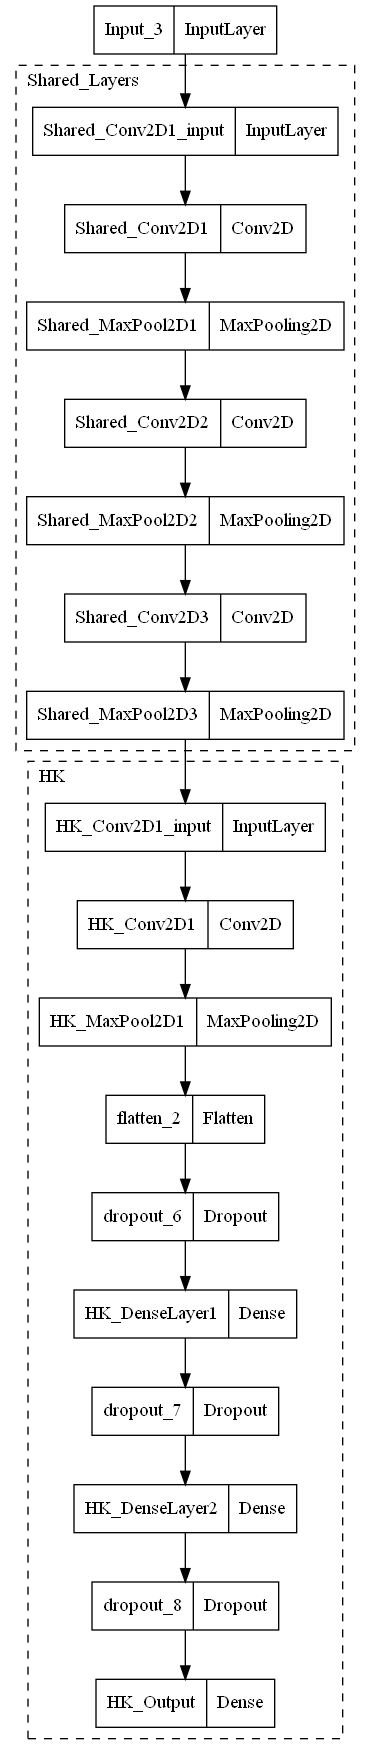

In [26]:
input3 = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='Input_3')

shared3.trainable = False
sharedLayers3 = shared3(input3)
individualLayers3 = languagelayers(NUM_LABELS_HK,'HK')(sharedLayers3)

model3 = tf.keras.Model(
    inputs=[input3],
    outputs=[individualLayers3],
    name='Full_Model_3'
)

model3.summary(expand_nested=True)
tf.keras.utils.plot_model(model3, expand_nested=True)


In [27]:
model3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)


In [28]:
training_callback3 = callbacks.TensorBoard(log_dir=LOG_DIR + '3')
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint3 = callbacks.ModelCheckpoint(
    filepath=MODEL_SAVE_PATH + '3',
    save_weights_only=False,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [29]:
history3 = model3.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback3,earlystopping_callback,reduce_lr_callback,checkpoint3],
    verbose=1
)


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 2.7507 - Categorical_Accuracy: 0.0820 - AUC: 0.5188

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 4s 351ms/step - loss: 2.7507 - Categorical_Accuracy: 0.0820 - AUC: 0.5188 - val_loss: 2.4425 - val_Categorical_Accuracy: 0.1286 - val_AUC: 0.5936 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 2.5075 - Categorical_Accuracy: 0.1440 - AUC: 0.5584

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 321ms/step - loss: 2.5075 - Categorical_Accuracy: 0.1440 - AUC: 0.5584 - val_loss: 2.3797 - val_Categorical_Accuracy: 0.1918 - val_AUC: 0.6722 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 2.4073 - Categorical_Accuracy: 0.1660 - AUC: 0.6142

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 341ms/step - loss: 2.4073 - Categorical_Accuracy: 0.1660 - AUC: 0.6142 - val_loss: 2.3298 - val_Categorical_Accuracy: 0.2184 - val_AUC: 0.7098 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 2.3627 - Categorical_Accuracy: 0.1520 - AUC: 0.6440

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 4s 403ms/step - loss: 2.3627 - Categorical_Accuracy: 0.1520 - AUC: 0.6440 - val_loss: 2.2794 - val_Categorical_Accuracy: 0.2286 - val_AUC: 0.7597 - lr: 1.0000e-04
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 2.2908 - Categorical_Accuracy: 0.2000 - AUC: 0.6887

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 342ms/step - loss: 2.2908 - Categorical_Accuracy: 0.2000 - AUC: 0.6887 - val_loss: 2.2278 - val_Categorical_Accuracy: 0.2571 - val_AUC: 0.7864 - lr: 1.0000e-04
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 2.2723 - Categorical_Accuracy: 0.2100 - AUC: 0.6976

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 328ms/step - loss: 2.2723 - Categorical_Accuracy: 0.2100 - AUC: 0.6976 - val_loss: 2.1683 - val_Categorical_Accuracy: 0.2816 - val_AUC: 0.7984 - lr: 1.0000e-04
Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 2.2049 - Categorical_Accuracy: 0.2340 - AUC: 0.7260

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 327ms/step - loss: 2.2049 - Categorical_Accuracy: 0.2340 - AUC: 0.7260 - val_loss: 2.1189 - val_Categorical_Accuracy: 0.3163 - val_AUC: 0.8122 - lr: 1.0000e-04
Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 2.1503 - Categorical_Accuracy: 0.2480 - AUC: 0.7554

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 377ms/step - loss: 2.1503 - Categorical_Accuracy: 0.2480 - AUC: 0.7554 - val_loss: 2.0755 - val_Categorical_Accuracy: 0.3429 - val_AUC: 0.8281 - lr: 1.0000e-04
Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 2.0562 - Categorical_Accuracy: 0.3120 - AUC: 0.7895

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 312ms/step - loss: 2.0562 - Categorical_Accuracy: 0.3120 - AUC: 0.7895 - val_loss: 2.0037 - val_Categorical_Accuracy: 0.3612 - val_AUC: 0.8387 - lr: 1.0000e-04
Epoch 10/100
10/10 [==============================] - ETA: 0s - loss: 1.9992 - Categorical_Accuracy: 0.3140 - AUC: 0.8043

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 322ms/step - loss: 1.9992 - Categorical_Accuracy: 0.3140 - AUC: 0.8043 - val_loss: 1.9423 - val_Categorical_Accuracy: 0.3714 - val_AUC: 0.8474 - lr: 1.0000e-04
Epoch 11/100
10/10 [==============================] - ETA: 0s - loss: 1.9544 - Categorical_Accuracy: 0.3180 - AUC: 0.8104

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 379ms/step - loss: 1.9544 - Categorical_Accuracy: 0.3180 - AUC: 0.8104 - val_loss: 1.8744 - val_Categorical_Accuracy: 0.3939 - val_AUC: 0.8544 - lr: 1.0000e-04
Epoch 12/100
10/10 [==============================] - ETA: 0s - loss: 1.8560 - Categorical_Accuracy: 0.3560 - AUC: 0.8430

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 286ms/step - loss: 1.8560 - Categorical_Accuracy: 0.3560 - AUC: 0.8430 - val_loss: 1.8048 - val_Categorical_Accuracy: 0.4327 - val_AUC: 0.8720 - lr: 1.0000e-04
Epoch 13/100
10/10 [==============================] - ETA: 0s - loss: 1.8235 - Categorical_Accuracy: 0.3260 - AUC: 0.8500 - ETA: 0s - loss: 1.8516 - Categorical_Accuracy: 0.3120 - AUC: 0.8434

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 291ms/step - loss: 1.8235 - Categorical_Accuracy: 0.3260 - AUC: 0.8500 - val_loss: 1.7381 - val_Categorical_Accuracy: 0.4633 - val_AUC: 0.8838 - lr: 1.0000e-04
Epoch 14/100
10/10 [==============================] - ETA: 0s - loss: 1.7689 - Categorical_Accuracy: 0.4040 - AUC: 0.8543

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 336ms/step - loss: 1.7689 - Categorical_Accuracy: 0.4040 - AUC: 0.8543 - val_loss: 1.6979 - val_Categorical_Accuracy: 0.4694 - val_AUC: 0.8887 - lr: 1.0000e-04
Epoch 15/100
10/10 [==============================] - ETA: 0s - loss: 1.7137 - Categorical_Accuracy: 0.4020 - AUC: 0.8738

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 282ms/step - loss: 1.7137 - Categorical_Accuracy: 0.4020 - AUC: 0.8738 - val_loss: 1.6586 - val_Categorical_Accuracy: 0.4776 - val_AUC: 0.8952 - lr: 1.0000e-04
Epoch 16/100
10/10 [==============================] - ETA: 0s - loss: 1.6264 - Categorical_Accuracy: 0.4440 - AUC: 0.8895

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 2s 269ms/step - loss: 1.6264 - Categorical_Accuracy: 0.4440 - AUC: 0.8895 - val_loss: 1.6024 - val_Categorical_Accuracy: 0.5163 - val_AUC: 0.9029 - lr: 1.0000e-04
Epoch 17/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.5946 - Categorical_Accuracy: 0.4400 - AUC: 0.8914

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 280ms/step - loss: 1.6032 - Categorical_Accuracy: 0.4320 - AUC: 0.8902 - val_loss: 1.5553 - val_Categorical_Accuracy: 0.5367 - val_AUC: 0.9075 - lr: 1.0000e-04
Epoch 18/100
10/10 [==============================] - ETA: 0s - loss: 1.5281 - Categorical_Accuracy: 0.4880 - AUC: 0.8997

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 329ms/step - loss: 1.5281 - Categorical_Accuracy: 0.4880 - AUC: 0.8997 - val_loss: 1.5110 - val_Categorical_Accuracy: 0.5449 - val_AUC: 0.9106 - lr: 1.0000e-04
Epoch 19/100
10/10 [==============================] - ETA: 0s - loss: 1.4692 - Categorical_Accuracy: 0.4960 - AUC: 0.9082

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 320ms/step - loss: 1.4692 - Categorical_Accuracy: 0.4960 - AUC: 0.9082 - val_loss: 1.4771 - val_Categorical_Accuracy: 0.5408 - val_AUC: 0.9146 - lr: 1.0000e-04
Epoch 20/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.4307 - Categorical_Accuracy: 0.5089 - AUC: 0.9168

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 286ms/step - loss: 1.4258 - Categorical_Accuracy: 0.5080 - AUC: 0.9173 - val_loss: 1.4308 - val_Categorical_Accuracy: 0.5653 - val_AUC: 0.9210 - lr: 1.0000e-04
Epoch 21/100
10/10 [==============================] - ETA: 0s - loss: 1.3501 - Categorical_Accuracy: 0.5520 - AUC: 0.9266

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 321ms/step - loss: 1.3501 - Categorical_Accuracy: 0.5520 - AUC: 0.9266 - val_loss: 1.3875 - val_Categorical_Accuracy: 0.5633 - val_AUC: 0.9247 - lr: 1.0000e-04
Epoch 22/100
10/10 [==============================] - ETA: 0s - loss: 1.3147 - Categorical_Accuracy: 0.5460 - AUC: 0.9292

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 339ms/step - loss: 1.3147 - Categorical_Accuracy: 0.5460 - AUC: 0.9292 - val_loss: 1.3427 - val_Categorical_Accuracy: 0.5776 - val_AUC: 0.9301 - lr: 1.0000e-04
Epoch 23/100
10/10 [==============================] - ETA: 0s - loss: 1.2575 - Categorical_Accuracy: 0.5820 - AUC: 0.9374

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 329ms/step - loss: 1.2575 - Categorical_Accuracy: 0.5820 - AUC: 0.9374 - val_loss: 1.3153 - val_Categorical_Accuracy: 0.5939 - val_AUC: 0.9323 - lr: 1.0000e-04
Epoch 24/100
10/10 [==============================] - ETA: 0s - loss: 1.2711 - Categorical_Accuracy: 0.5660 - AUC: 0.9342

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 360ms/step - loss: 1.2711 - Categorical_Accuracy: 0.5660 - AUC: 0.9342 - val_loss: 1.2966 - val_Categorical_Accuracy: 0.5714 - val_AUC: 0.9326 - lr: 1.0000e-04
Epoch 25/100
10/10 [==============================] - ETA: 0s - loss: 1.1776 - Categorical_Accuracy: 0.6080 - AUC: 0.9456

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 292ms/step - loss: 1.1776 - Categorical_Accuracy: 0.6080 - AUC: 0.9456 - val_loss: 1.2526 - val_Categorical_Accuracy: 0.5980 - val_AUC: 0.9371 - lr: 1.0000e-04
Epoch 26/100
10/10 [==============================] - ETA: 0s - loss: 1.1267 - Categorical_Accuracy: 0.6360 - AUC: 0.9509

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 299ms/step - loss: 1.1267 - Categorical_Accuracy: 0.6360 - AUC: 0.9509 - val_loss: 1.2313 - val_Categorical_Accuracy: 0.5857 - val_AUC: 0.9389 - lr: 1.0000e-04
Epoch 27/100
10/10 [==============================] - ETA: 0s - loss: 1.1110 - Categorical_Accuracy: 0.6060 - AUC: 0.9509

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 316ms/step - loss: 1.1110 - Categorical_Accuracy: 0.6060 - AUC: 0.9509 - val_loss: 1.2064 - val_Categorical_Accuracy: 0.6061 - val_AUC: 0.9412 - lr: 1.0000e-04
Epoch 28/100
10/10 [==============================] - ETA: 0s - loss: 1.1050 - Categorical_Accuracy: 0.6380 - AUC: 0.9498

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 320ms/step - loss: 1.1050 - Categorical_Accuracy: 0.6380 - AUC: 0.9498 - val_loss: 1.1800 - val_Categorical_Accuracy: 0.6367 - val_AUC: 0.9435 - lr: 1.0000e-04
Epoch 29/100
10/10 [==============================] - ETA: 0s - loss: 1.0298 - Categorical_Accuracy: 0.6600 - AUC: 0.9592

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 2s 267ms/step - loss: 1.0298 - Categorical_Accuracy: 0.6600 - AUC: 0.9592 - val_loss: 1.1687 - val_Categorical_Accuracy: 0.6102 - val_AUC: 0.9448 - lr: 1.0000e-04
Epoch 30/100
10/10 [==============================] - ETA: 0s - loss: 1.0055 - Categorical_Accuracy: 0.6720 - AUC: 0.9612

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 2s 270ms/step - loss: 1.0055 - Categorical_Accuracy: 0.6720 - AUC: 0.9612 - val_loss: 1.1362 - val_Categorical_Accuracy: 0.6122 - val_AUC: 0.9473 - lr: 1.0000e-04
Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 0.9845 - Categorical_Accuracy: 0.6560 - AUC: 0.9616

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 313ms/step - loss: 0.9845 - Categorical_Accuracy: 0.6560 - AUC: 0.9616 - val_loss: 1.1102 - val_Categorical_Accuracy: 0.6469 - val_AUC: 0.9492 - lr: 1.0000e-04
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 0.9738 - Categorical_Accuracy: 0.6560 - AUC: 0.9622

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 284ms/step - loss: 0.8817 - Categorical_Accuracy: 0.7040 - AUC: 0.9710 - val_loss: 1.0892 - val_Categorical_Accuracy: 0.6327 - val_AUC: 0.9510 - lr: 1.0000e-04
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.8561 - Categorical_Accuracy: 0.7280 - AUC: 0.9729

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 291ms/step - loss: 0.8561 - Categorical_Accuracy: 0.7280 - AUC: 0.9729 - val_loss: 1.0587 - val_Categorical_Accuracy: 0.6531 - val_AUC: 0.9528 - lr: 1.0000e-04
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.7694 - Categorical_Accuracy: 0.7780 - AUC: 0.9796

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 316ms/step - loss: 0.7694 - Categorical_Accuracy: 0.7780 - AUC: 0.9796 - val_loss: 1.0353 - val_Categorical_Accuracy: 0.6531 - val_AUC: 0.9538 - lr: 1.0000e-04
Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 0.8120 - Categorical_Accuracy: 0.7200 - AUC: 0.9737

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 279ms/step - loss: 0.8120 - Categorical_Accuracy: 0.7200 - AUC: 0.9737 - val_loss: 1.0284 - val_Categorical_Accuracy: 0.6490 - val_AUC: 0.9535 - lr: 1.0000e-04
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.8292 - Categorical_Accuracy: 0.7380 - AUC: 0.9727

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 292ms/step - loss: 0.8292 - Categorical_Accuracy: 0.7380 - AUC: 0.9727 - val_loss: 1.0143 - val_Categorical_Accuracy: 0.6449 - val_AUC: 0.9555 - lr: 1.0000e-04
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.8004 - Categorical_Accuracy: 0.7200 - AUC: 0.9751

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 276ms/step - loss: 0.8004 - Categorical_Accuracy: 0.7200 - AUC: 0.9751 - val_loss: 1.0132 - val_Categorical_Accuracy: 0.6735 - val_AUC: 0.9554 - lr: 1.0000e-04
Epoch 39/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7484 - Categorical_Accuracy: 0.7622 - AUC: 0.9781

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 307ms/step - loss: 0.7429 - Categorical_Accuracy: 0.7620 - AUC: 0.9787 - val_loss: 0.9964 - val_Categorical_Accuracy: 0.6633 - val_AUC: 0.9566 - lr: 1.0000e-04
Epoch 40/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7770 - Categorical_Accuracy: 0.7622 - AUC: 0.9753

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 275ms/step - loss: 0.7715 - Categorical_Accuracy: 0.7660 - AUC: 0.9760 - val_loss: 0.9947 - val_Categorical_Accuracy: 0.6735 - val_AUC: 0.9563 - lr: 1.0000e-04
Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 0.7038 - Categorical_Accuracy: 0.7760 - AUC: 0.9828
Epoch 00041: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 273ms/step - loss: 0.7038 - Categorical_Accuracy: 0.7760 - AUC: 0.9828 - val_loss: 0.9796 - val_Categorical_Accuracy: 0.6653 - val_AUC: 0.9580 - lr: 1.0000e-04
Epoch 42/100
10/10 [==============================] - ETA: 0s - loss: 0.6917 - Categorical_Accuracy: 0.7820 - AUC: 0.9828

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 317ms/step - loss: 0.6917 - Categorical_Accuracy: 0.7820 - AUC: 0.9828 - val_loss: 0.9721 - val_Categorical_Accuracy: 0.6571 - val_AUC: 0.9580 - lr: 1.0000e-04
Epoch 43/100
10/10 [==============================] - ETA: 0s - loss: 0.6751 - Categorical_Accuracy: 0.7880 - AUC: 0.9834

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 280ms/step - loss: 0.6845 - Categorical_Accuracy: 0.7800 - AUC: 0.9828 - val_loss: 0.9661 - val_Categorical_Accuracy: 0.6633 - val_AUC: 0.9575 - lr: 1.0000e-04
Epoch 45/100
10/10 [==============================] - ETA: 0s - loss: 0.6218 - Categorical_Accuracy: 0.7940 - AUC: 0.9862

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 278ms/step - loss: 0.6218 - Categorical_Accuracy: 0.7940 - AUC: 0.9862 - val_loss: 0.9615 - val_Categorical_Accuracy: 0.6612 - val_AUC: 0.9580 - lr: 1.0000e-04
Epoch 46/100
10/10 [==============================] - ETA: 0s - loss: 0.5972 - Categorical_Accuracy: 0.8280 - AUC: 0.9863

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 312ms/step - loss: 0.5972 - Categorical_Accuracy: 0.8280 - AUC: 0.9863 - val_loss: 0.9326 - val_Categorical_Accuracy: 0.6796 - val_AUC: 0.9606 - lr: 1.0000e-04
Epoch 47/100
10/10 [==============================] - ETA: 0s - loss: 0.6172 - Categorical_Accuracy: 0.8020 - AUC: 0.9848

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 306ms/step - loss: 0.6172 - Categorical_Accuracy: 0.8020 - AUC: 0.9848 - val_loss: 0.9247 - val_Categorical_Accuracy: 0.6918 - val_AUC: 0.9610 - lr: 1.0000e-04
Epoch 48/100
10/10 [==============================] - ETA: 0s - loss: 0.5657 - Categorical_Accuracy: 0.8360 - AUC: 0.9891 - ETA: 0s - loss: 0.5628 - Categorical_Accuracy: 0.8440 - AUC: 0.9889

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 294ms/step - loss: 0.5364 - Categorical_Accuracy: 0.8260 - AUC: 0.9893 - val_loss: 0.9162 - val_Categorical_Accuracy: 0.6878 - val_AUC: 0.9615 - lr: 1.0000e-04
Epoch 50/100
10/10 [==============================] - ETA: 0s - loss: 0.4871 - Categorical_Accuracy: 0.8600 - AUC: 0.9924

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 293ms/step - loss: 0.4871 - Categorical_Accuracy: 0.8600 - AUC: 0.9924 - val_loss: 0.9031 - val_Categorical_Accuracy: 0.6735 - val_AUC: 0.9625 - lr: 1.0000e-04
Epoch 51/100
10/10 [==============================] - ETA: 0s - loss: 0.5377 - Categorical_Accuracy: 0.8200 - AUC: 0.9899

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 314ms/step - loss: 0.5075 - Categorical_Accuracy: 0.8420 - AUC: 0.9911 - val_loss: 0.8976 - val_Categorical_Accuracy: 0.6776 - val_AUC: 0.9630 - lr: 2.0000e-05
Epoch 54/100
10/10 [==============================] - ETA: 0s - loss: 0.5187 - Categorical_Accuracy: 0.8420 - AUC: 0.9896

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 280ms/step - loss: 0.5187 - Categorical_Accuracy: 0.8420 - AUC: 0.9896 - val_loss: 0.8921 - val_Categorical_Accuracy: 0.6918 - val_AUC: 0.9634 - lr: 2.0000e-05
Epoch 55/100
10/10 [==============================] - ETA: 0s - loss: 0.4776 - Categorical_Accuracy: 0.8540 - AUC: 0.9925

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 293ms/step - loss: 0.4592 - Categorical_Accuracy: 0.8840 - AUC: 0.9937 - val_loss: 0.8908 - val_Categorical_Accuracy: 0.6898 - val_AUC: 0.9635 - lr: 2.0000e-05
Epoch 57/100
10/10 [==============================] - ETA: 0s - loss: 0.4827 - Categorical_Accuracy: 0.8500 - AUC: 0.9922

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 355ms/step - loss: 0.4827 - Categorical_Accuracy: 0.8500 - AUC: 0.9922 - val_loss: 0.8888 - val_Categorical_Accuracy: 0.6878 - val_AUC: 0.9637 - lr: 2.0000e-05
Epoch 58/100
10/10 [==============================] - ETA: 0s - loss: 0.5050 - Categorical_Accuracy: 0.8420 - AUC: 0.9912

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 2s 272ms/step - loss: 0.4997 - Categorical_Accuracy: 0.8420 - AUC: 0.9911 - val_loss: 0.8873 - val_Categorical_Accuracy: 0.6857 - val_AUC: 0.9631 - lr: 2.0000e-05
Epoch 60/100
10/10 [==============================] - ETA: 0s - loss: 0.4265 - Categorical_Accuracy: 0.8940 - AUC: 0.9946

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 301ms/step - loss: 0.4265 - Categorical_Accuracy: 0.8940 - AUC: 0.9946 - val_loss: 0.8857 - val_Categorical_Accuracy: 0.6939 - val_AUC: 0.9639 - lr: 2.0000e-05
Epoch 61/100
10/10 [==============================] - ETA: 0s - loss: 0.4798 - Categorical_Accuracy: 0.8360 - AUC: 0.9920

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 326ms/step - loss: 0.4408 - Categorical_Accuracy: 0.8740 - AUC: 0.9933 - val_loss: 0.8855 - val_Categorical_Accuracy: 0.6878 - val_AUC: 0.9638 - lr: 2.0000e-05
Epoch 63/100
10/10 [==============================] - ETA: 0s - loss: 0.4155 - Categorical_Accuracy: 0.8920 - AUC: 0.9951

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 305ms/step - loss: 0.4378 - Categorical_Accuracy: 0.8660 - AUC: 0.9935 - val_loss: 0.8825 - val_Categorical_Accuracy: 0.6939 - val_AUC: 0.9640 - lr: 1.0000e-05
Epoch 67/100
10/10 [==============================] - ETA: 0s - loss: 0.4172 - Categorical_Accuracy: 0.8780 - AUC: 0.9946

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 304ms/step - loss: 0.4172 - Categorical_Accuracy: 0.8780 - AUC: 0.9946 - val_loss: 0.8824 - val_Categorical_Accuracy: 0.6918 - val_AUC: 0.9640 - lr: 1.0000e-05
Epoch 68/100
10/10 [==============================] - ETA: 0s - loss: 0.4488 - Categorical_Accuracy: 0.8700 - AUC: 0.9922

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 285ms/step - loss: 0.4488 - Categorical_Accuracy: 0.8700 - AUC: 0.9922 - val_loss: 0.8816 - val_Categorical_Accuracy: 0.6939 - val_AUC: 0.9640 - lr: 1.0000e-05
Epoch 69/100
10/10 [==============================] - ETA: 0s - loss: 0.4384 - Categorical_Accuracy: 0.8680 - AUC: 0.9936

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 313ms/step - loss: 0.4384 - Categorical_Accuracy: 0.8680 - AUC: 0.9936 - val_loss: 0.8811 - val_Categorical_Accuracy: 0.6898 - val_AUC: 0.9634 - lr: 1.0000e-05
Epoch 70/100
10/10 [==============================] - ETA: 0s - loss: 0.4567 - Categorical_Accuracy: 0.8500 - AUC: 0.9933

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 283ms/step - loss: 0.4101 - Categorical_Accuracy: 0.8820 - AUC: 0.9951 - val_loss: 0.8799 - val_Categorical_Accuracy: 0.6898 - val_AUC: 0.9635 - lr: 1.0000e-05
Epoch 75/100
10/10 [==============================] - ETA: 0s - loss: 0.4435 - Categorical_Accuracy: 0.8600 - AUC: 0.9929

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 282ms/step - loss: 0.4435 - Categorical_Accuracy: 0.8600 - AUC: 0.9929 - val_loss: 0.8796 - val_Categorical_Accuracy: 0.6878 - val_AUC: 0.9635 - lr: 1.0000e-05
Epoch 76/100
10/10 [==============================] - ETA: 0s - loss: 0.4114 - Categorical_Accuracy: 0.8820 - AUC: 0.9947

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 332ms/step - loss: 0.4114 - Categorical_Accuracy: 0.8820 - AUC: 0.9947 - val_loss: 0.8782 - val_Categorical_Accuracy: 0.6939 - val_AUC: 0.9636 - lr: 1.0000e-05
Epoch 77/100
10/10 [==============================] - ETA: 0s - loss: 0.4175 - Categorical_Accuracy: 0.8700 - AUC: 0.9943

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 283ms/step - loss: 0.4175 - Categorical_Accuracy: 0.8700 - AUC: 0.9943 - val_loss: 0.8780 - val_Categorical_Accuracy: 0.6878 - val_AUC: 0.9634 - lr: 1.0000e-05
Epoch 78/100
10/10 [==============================] - ETA: 0s - loss: 0.4098 - Categorical_Accuracy: 0.8880 - AUC: 0.9945

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


10/10 [==============================] - 3s 285ms/step - loss: 0.4548 - Categorical_Accuracy: 0.8640 - AUC: 0.9924 - val_loss: 0.8775 - val_Categorical_Accuracy: 0.6918 - val_AUC: 0.9637 - lr: 1.0000e-05
Epoch 80/100
10/10 [==============================] - ETA: 0s - loss: 0.4544 - Categorical_Accuracy: 0.8660 - AUC: 0.9923

In [30]:
model3c = keras.models.load_model('savedcheckpoints3')
model3c.evaluate(testdatasetHK)


250/250 [==============================] - 2s 6ms/step - loss: 1.0138 - Categorical_Accuracy: 0.6720 - AUC: 0.9476

[1.0137629508972168, 0.671999990940094, 0.9475620985031128]

Model: "Full_Model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_4 (InputLayer)        [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                               

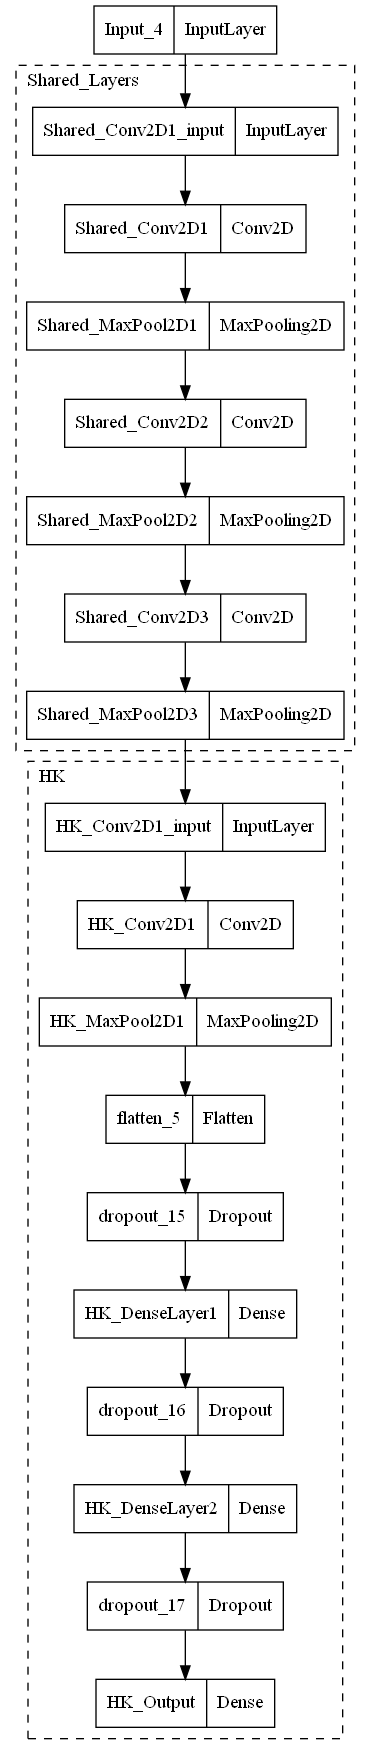

In [38]:
input4 = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='Input_4')

shared4.trainable = False
sharedLayers4 = shared4(input4)
individualLayers4 = languagelayers(NUM_LABELS_HK,'HK')(sharedLayers4)

model4 = tf.keras.Model(
    inputs=[input4],
    outputs=[individualLayers4],
    name='Full_Model_4'
)

model4.summary(expand_nested=True)
tf.keras.utils.plot_model(model4, expand_nested=True)


In [39]:
model4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)


In [40]:
training_callback4 = callbacks.TensorBoard(log_dir=LOG_DIR + '4')
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint4 = callbacks.ModelCheckpoint(
    filepath=MODEL_SAVE_PATH + '4',
    save_weights_only=False,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [41]:
history4 = model4.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback4,earlystopping_callback,reduce_lr_callback,checkpoint4],
    verbose=1
)


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 2.8077 - Categorical_Accuracy: 0.1020 - AUC: 0.4999 
Epoch 00001: 

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 4s 299ms/step - loss: 2.8077 - Categorical_Accuracy: 0.1020 - AUC: 0.4999 - val_loss: 2.4752 - val_Categorical_Accuracy: 0.0837 - val_AUC: 0.5572 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 2.5284 - Categorical_Accuracy: 0.1160 - AUC: 0.5632

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 301ms/step - loss: 2.5284 - Categorical_Accuracy: 0.1160 - AUC: 0.5632 - val_loss: 2.3955 - val_Categorical_Accuracy: 0.1633 - val_AUC: 0.6244 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 2.4356 - Categorical_Accuracy: 0.1360 - AUC: 0.6070
Epoch 00003: val_loss impro

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 275ms/step - loss: 2.4356 - Categorical_Accuracy: 0.1360 - AUC: 0.6070 - val_loss: 2.3368 - val_Categorical_Accuracy: 0.2020 - val_AUC: 0.6878 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 2.3559 - Categorical_Accuracy: 0.1680 - AUC: 0.6520

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 279ms/step - loss: 2.3559 - Categorical_Accuracy: 0.1680 - AUC: 0.6520 - val_loss: 2.2843 - val_Categorical_Accuracy: 0.2184 - val_AUC: 0.7201 - lr: 1.0000e-04
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 2.2924 - Categorical_Accuracy: 0.1900 - AUC: 0.6829

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 297ms/step - loss: 2.2924 - Categorical_Accuracy: 0.1900 - AUC: 0.6829 - val_loss: 2.2269 - val_Categorical_Accuracy: 0.2102 - val_AUC: 0.7501 - lr: 1.0000e-04
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 2.2397 - Categorical_Accuracy: 0.2020 - AUC: 0.7078

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 345ms/step - loss: 2.2397 - Categorical_Accuracy: 0.2020 - AUC: 0.7078 - val_loss: 2.1737 - val_Categorical_Accuracy: 0.2449 - val_AUC: 0.7682 - lr: 1.0000e-04
Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 2.1523 - Categorical_Accuracy: 0.2300 - AUC: 0.7468

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 303ms/step - loss: 2.1523 - Categorical_Accuracy: 0.2300 - AUC: 0.7468 - val_loss: 2.1121 - val_Categorical_Accuracy: 0.2816 - val_AUC: 0.7849 - lr: 1.0000e-04
Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 2.0943 - Categorical_Accuracy: 0.2620 - AUC: 0.7697

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 280ms/step - loss: 2.0943 - Categorical_Accuracy: 0.2620 - AUC: 0.7697 - val_loss: 2.0547 - val_Categorical_Accuracy: 0.2735 - val_AUC: 0.7942 - lr: 1.0000e-04
Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 2.0519 - Categorical_Accuracy: 0.2940 - AUC: 0.7814

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 287ms/step - loss: 2.0519 - Categorical_Accuracy: 0.2940 - AUC: 0.7814 - val_loss: 2.0160 - val_Categorical_Accuracy: 0.2918 - val_AUC: 0.8076 - lr: 1.0000e-04
Epoch 10/100
10/10 [==============================] - ETA: 0s - loss: 2.0199 - Categorical_Accuracy: 0.3000 - AUC: 0.7875

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 314ms/step - loss: 2.0199 - Categorical_Accuracy: 0.3000 - AUC: 0.7875 - val_loss: 1.9610 - val_Categorical_Accuracy: 0.3245 - val_AUC: 0.8310 - lr: 1.0000e-04
Epoch 11/100
10/10 [==============================] - ETA: 0s - loss: 1.9595 - Categorical_Accuracy: 0.3120 - AUC: 0.8111

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 292ms/step - loss: 1.9595 - Categorical_Accuracy: 0.3120 - AUC: 0.8111 - val_loss: 1.9196 - val_Categorical_Accuracy: 0.3694 - val_AUC: 0.8344 - lr: 1.0000e-04
Epoch 12/100
10/10 [==============================] - ETA: 0s - loss: 1.9035 - Categorical_Accuracy: 0.3460 - AUC: 0.8280

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 288ms/step - loss: 1.9035 - Categorical_Accuracy: 0.3460 - AUC: 0.8280 - val_loss: 1.8657 - val_Categorical_Accuracy: 0.3735 - val_AUC: 0.8456 - lr: 1.0000e-04
Epoch 13/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.8312 - Categorical_Accuracy: 0.3622 - AUC: 0.8441
Epoch 00013: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 305ms/step - loss: 1.8306 - Categorical_Accuracy: 0.3640 - AUC: 0.8436 - val_loss: 1.8074 - val_Categorical_Accuracy: 0.4122 - val_AUC: 0.8593 - lr: 1.0000e-04
Epoch 14/100
10/10 [==============================] - ETA: 0s - loss: 1.7688 - Categorical_Accuracy: 0.3820 - AUC: 0.8547

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 273ms/step - loss: 1.7688 - Categorical_Accuracy: 0.3820 - AUC: 0.8547 - val_loss: 1.7618 - val_Categorical_Accuracy: 0.4184 - val_AUC: 0.8706 - lr: 1.0000e-04
Epoch 15/100
10/10 [==============================] - ETA: 0s - loss: 1.7121 - Categorical_Accuracy: 0.4180 - AUC: 0.8665
Epoch 00015: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 275ms/step - loss: 1.7121 - Categorical_Accuracy: 0.4180 - AUC: 0.8665 - val_loss: 1.7235 - val_Categorical_Accuracy: 0.4265 - val_AUC: 0.8770 - lr: 1.0000e-04
Epoch 16/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.6740 - Categorical_Accuracy: 0.4089 - AUC: 0.8770
Epoch 00016: val_loss improved from 1.72355 to 1.68664, saving model to savedcheckpoints4


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 2s 271ms/step - loss: 1.6707 - Categorical_Accuracy: 0.4120 - AUC: 0.8766 - val_loss: 1.6866 - val_Categorical_Accuracy: 0.4449 - val_AUC: 0.8816 - lr: 1.0000e-04
Epoch 17/100
10/10 [==============================] - ETA: 0s - loss: 1.6561 - Categorical_Accuracy: 0.4520 - AUC: 0.8757

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 310ms/step - loss: 1.6561 - Categorical_Accuracy: 0.4520 - AUC: 0.8757 - val_loss: 1.6459 - val_Categorical_Accuracy: 0.4857 - val_AUC: 0.8892 - lr: 1.0000e-04
Epoch 18/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.5914 - Categorical_Accuracy: 0.4667 - AUC: 0.8900
Epoch 00018: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 275ms/step - loss: 1.5953 - Categorical_Accuracy: 0.4680 - AUC: 0.8889 - val_loss: 1.5986 - val_Categorical_Accuracy: 0.5102 - val_AUC: 0.8947 - lr: 1.0000e-04
Epoch 19/100
10/10 [==============================] - ETA: 0s - loss: 1.5240 - Categorical_Accuracy: 0.4700 - AUC: 0.8981
Epoch 00019: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 274ms/step - loss: 1.5240 - Categorical_Accuracy: 0.4700 - AUC: 0.8981 - val_loss: 1.5529 - val_Categorical_Accuracy: 0.4776 - val_AUC: 0.9001 - lr: 1.0000e-04
Epoch 20/100
10/10 [==============================] - ETA: 0s - loss: 1.4951 - Categorical_Accuracy: 0.5000 - AUC: 0.9049

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 274ms/step - loss: 1.4951 - Categorical_Accuracy: 0.5000 - AUC: 0.9049 - val_loss: 1.5097 - val_Categorical_Accuracy: 0.5204 - val_AUC: 0.9061 - lr: 1.0000e-04
Epoch 21/100
10/10 [==============================] - ETA: 0s - loss: 1.4475 - Categorical_Accuracy: 0.5100 - AUC: 0.9104
Epoch 00021: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 304ms/step - loss: 1.4475 - Categorical_Accuracy: 0.5100 - AUC: 0.9104 - val_loss: 1.4972 - val_Categorical_Accuracy: 0.5061 - val_AUC: 0.9070 - lr: 1.0000e-04
Epoch 22/100
10/10 [==============================] - ETA: 0s - loss: 1.3192 - Categorical_Accuracy: 0.6020 - AUC: 0.9316
Epoch 00022: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 2s 271ms/step - loss: 1.3192 - Categorical_Accuracy: 0.6020 - AUC: 0.9316 - val_loss: 1.4405 - val_Categorical_Accuracy: 0.5245 - val_AUC: 0.9137 - lr: 1.0000e-04
Epoch 23/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.2969 - Categorical_Accuracy: 0.5867 - AUC: 0.9314
Epoch 00023: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 274ms/step - loss: 1.2889 - Categorical_Accuracy: 0.5780 - AUC: 0.9325 - val_loss: 1.4062 - val_Categorical_Accuracy: 0.5347 - val_AUC: 0.9175 - lr: 1.0000e-04
Epoch 24/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.2114 - Categorical_Accuracy: 0.5844 - AUC: 0.9410

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 308ms/step - loss: 1.2155 - Categorical_Accuracy: 0.5860 - AUC: 0.9408 - val_loss: 1.3563 - val_Categorical_Accuracy: 0.5571 - val_AUC: 0.9233 - lr: 1.0000e-04
Epoch 25/100
10/10 [==============================] - ETA: 0s - loss: 1.3136 - Categorical_Accuracy: 0.5540 - AUC: 0.9257

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 275ms/step - loss: 1.3136 - Categorical_Accuracy: 0.5540 - AUC: 0.9257 - val_loss: 1.3475 - val_Categorical_Accuracy: 0.5490 - val_AUC: 0.9241 - lr: 1.0000e-04
Epoch 26/100
10/10 [==============================] - ETA: 0s - loss: 1.1839 - Categorical_Accuracy: 0.6080 - AUC: 0.9461

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 274ms/step - loss: 1.1839 - Categorical_Accuracy: 0.6080 - AUC: 0.9461 - val_loss: 1.3160 - val_Categorical_Accuracy: 0.5714 - val_AUC: 0.9291 - lr: 1.0000e-04
Epoch 27/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.1352 - Categorical_Accuracy: 0.6333 - AUC: 0.9484

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 2s 271ms/step - loss: 1.1460 - Categorical_Accuracy: 0.6340 - AUC: 0.9467 - val_loss: 1.3015 - val_Categorical_Accuracy: 0.5755 - val_AUC: 0.9288 - lr: 1.0000e-04
Epoch 28/100
10/10 [==============================] - ETA: 0s - loss: 1.0844 - Categorical_Accuracy: 0.6480 - AUC: 0.9560
Epoch 00028: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 323ms/step - loss: 1.0844 - Categorical_Accuracy: 0.6480 - AUC: 0.9560 - val_loss: 1.2558 - val_Categorical_Accuracy: 0.5980 - val_AUC: 0.9338 - lr: 1.0000e-04
Epoch 29/100
10/10 [==============================] - ETA: 0s - loss: 1.0204 - Categorical_Accuracy: 0.6540 - AUC: 0.9609

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 295ms/step - loss: 1.0204 - Categorical_Accuracy: 0.6540 - AUC: 0.9609 - val_loss: 1.2410 - val_Categorical_Accuracy: 0.5796 - val_AUC: 0.9347 - lr: 1.0000e-04
Epoch 30/100
10/10 [==============================] - ETA: 0s - loss: 1.0002 - Categorical_Accuracy: 0.6780 - AUC: 0.9618
Epoch 00030: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 295ms/step - loss: 1.0002 - Categorical_Accuracy: 0.6780 - AUC: 0.9618 - val_loss: 1.2069 - val_Categorical_Accuracy: 0.6082 - val_AUC: 0.9386 - lr: 1.0000e-04
Epoch 31/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.9425 - Categorical_Accuracy: 0.7022 - AUC: 0.9651
Epoch 00031: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 278ms/step - loss: 0.9556 - Categorical_Accuracy: 0.6960 - AUC: 0.9630 - val_loss: 1.2004 - val_Categorical_Accuracy: 0.5878 - val_AUC: 0.9380 - lr: 1.0000e-04
Epoch 32/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.9609 - Categorical_Accuracy: 0.6889 - AUC: 0.9633
Epoch 00032: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 311ms/step - loss: 0.9820 - Categorical_Accuracy: 0.6860 - AUC: 0.9602 - val_loss: 1.1665 - val_Categorical_Accuracy: 0.6020 - val_AUC: 0.9419 - lr: 1.0000e-04
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 0.9457 - Categorical_Accuracy: 0.7120 - AUC: 0.9647

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 283ms/step - loss: 0.9457 - Categorical_Accuracy: 0.7120 - AUC: 0.9647 - val_loss: 1.1499 - val_Categorical_Accuracy: 0.6184 - val_AUC: 0.9437 - lr: 1.0000e-04
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.9151 - Categorical_Accuracy: 0.6880 - AUC: 0.9684

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 289ms/step - loss: 0.9151 - Categorical_Accuracy: 0.6880 - AUC: 0.9684 - val_loss: 1.1403 - val_Categorical_Accuracy: 0.6082 - val_AUC: 0.9446 - lr: 1.0000e-04
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.8909 - Categorical_Accuracy: 0.7200 - AUC: 0.9705

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 298ms/step - loss: 0.8909 - Categorical_Accuracy: 0.7200 - AUC: 0.9705 - val_loss: 1.1300 - val_Categorical_Accuracy: 0.6102 - val_AUC: 0.9435 - lr: 1.0000e-04
Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 0.8943 - Categorical_Accuracy: 0.7120 - AUC: 0.9686

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 316ms/step - loss: 0.8943 - Categorical_Accuracy: 0.7120 - AUC: 0.9686 - val_loss: 1.1166 - val_Categorical_Accuracy: 0.6245 - val_AUC: 0.9451 - lr: 1.0000e-04
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.8057 - Categorical_Accuracy: 0.7340 - AUC: 0.9767

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 289ms/step - loss: 0.8057 - Categorical_Accuracy: 0.7340 - AUC: 0.9767 - val_loss: 1.0939 - val_Categorical_Accuracy: 0.6306 - val_AUC: 0.9474 - lr: 1.0000e-04
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.8215 - Categorical_Accuracy: 0.7380 - AUC: 0.9727

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 282ms/step - loss: 0.8215 - Categorical_Accuracy: 0.7380 - AUC: 0.9727 - val_loss: 1.0919 - val_Categorical_Accuracy: 0.6265 - val_AUC: 0.9483 - lr: 1.0000e-04
Epoch 39/100
10/10 [==============================] - ETA: 0s - loss: 0.7297 - Categorical_Accuracy: 0.7760 - AUC: 0.9815

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 329ms/step - loss: 0.7297 - Categorical_Accuracy: 0.7760 - AUC: 0.9815 - val_loss: 1.0836 - val_Categorical_Accuracy: 0.6347 - val_AUC: 0.9469 - lr: 1.0000e-04
Epoch 40/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.6998 - Categorical_Accuracy: 0.8000 - AUC: 0.9822

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 290ms/step - loss: 0.7083 - Categorical_Accuracy: 0.8000 - AUC: 0.9805 - val_loss: 1.0557 - val_Categorical_Accuracy: 0.6286 - val_AUC: 0.9502 - lr: 1.0000e-04
Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 0.7116 - Categorical_Accuracy: 0.7520 - AUC: 0.9819

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 299ms/step - loss: 0.6960 - Categorical_Accuracy: 0.7760 - AUC: 0.9820 - val_loss: 1.0427 - val_Categorical_Accuracy: 0.6429 - val_AUC: 0.9511 - lr: 1.0000e-04
Epoch 43/100
10/10 [==============================] - ETA: 0s - loss: 0.6757 - Categorical_Accuracy: 0.8000 - AUC: 0.9832
Epoch 00043: val_loss did 

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 270ms/step - loss: 0.6425 - Categorical_Accuracy: 0.8100 - AUC: 0.9850 - val_loss: 1.0234 - val_Categorical_Accuracy: 0.6388 - val_AUC: 0.9519 - lr: 1.0000e-04
Epoch 45/100
10/10 [==============================] - ETA: 0s - loss: 0.6323 - Categorical_Accuracy: 0.7960 - AUC: 0.9858

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 364ms/step - loss: 0.6323 - Categorical_Accuracy: 0.7960 - AUC: 0.9858 - val_loss: 1.0001 - val_Categorical_Accuracy: 0.6510 - val_AUC: 0.9544 - lr: 1.0000e-04
Epoch 46/100
10/10 [==============================] - ETA: 0s - loss: 0.6048 - Categorical_Accuracy: 0.8180 - AUC: 0.9871

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 289ms/step - loss: 0.6048 - Categorical_Accuracy: 0.8180 - AUC: 0.9871 - val_loss: 0.9820 - val_Categorical_Accuracy: 0.6673 - val_AUC: 0.9555 - lr: 1.0000e-04
Epoch 47/100
10/10 [==============================] - ETA: 0s - loss: 0.5924 - Categorical_Accuracy: 0.8140 - AUC: 0.9865

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 282ms/step - loss: 0.5589 - Categorical_Accuracy: 0.8180 - AUC: 0.9891 - val_loss: 0.9797 - val_Categorical_Accuracy: 0.6592 - val_AUC: 0.9564 - lr: 2.0000e-05
Epoch 50/100
10/10 [==============================] - ETA: 0s - loss: 0.5276 - Categorical_Accuracy: 0.8440 - AUC: 0.9901

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 278ms/step - loss: 0.5276 - Categorical_Accuracy: 0.8440 - AUC: 0.9901 - val_loss: 0.9750 - val_Categorical_Accuracy: 0.6633 - val_AUC: 0.9561 - lr: 2.0000e-05
Epoch 51/100
10/10 [==============================] - ETA: 0s - loss: 0.5547 - Categorical_Accuracy: 0.8440 - AUC: 0.9897

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 316ms/step - loss: 0.5547 - Categorical_Accuracy: 0.8440 - AUC: 0.9897 - val_loss: 0.9711 - val_Categorical_Accuracy: 0.6633 - val_AUC: 0.9564 - lr: 2.0000e-05
Epoch 52/100
10/10 [==============================] - ETA: 0s - loss: 0.5160 - Categorical_Accuracy: 0.8360 - AUC: 0.9905

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 276ms/step - loss: 0.5371 - Categorical_Accuracy: 0.8560 - AUC: 0.9897 - val_loss: 0.9660 - val_Categorical_Accuracy: 0.6653 - val_AUC: 0.9568 - lr: 2.0000e-05
Epoch 54/100
10/10 [==============================] - ETA: 0s - loss: 0.5507 - Categorical_Accuracy: 0.8400 - AUC: 0.9875

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 279ms/step - loss: 0.5507 - Categorical_Accuracy: 0.8400 - AUC: 0.9875 - val_loss: 0.9639 - val_Categorical_Accuracy: 0.6714 - val_AUC: 0.9571 - lr: 2.0000e-05
Epoch 55/100
10/10 [==============================] - ETA: 0s - loss: 0.5444 - Categorical_Accuracy: 0.8420 - AUC: 0.9906

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 277ms/step - loss: 0.5375 - Categorical_Accuracy: 0.8260 - AUC: 0.9902 - val_loss: 0.9633 - val_Categorical_Accuracy: 0.6673 - val_AUC: 0.9566 - lr: 1.0000e-05
Epoch 59/100
10/10 [==============================] - ETA: 0s - loss: 0.4939 - Categorical_Accuracy: 0.8740 - AUC: 0.9917

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 316ms/step - loss: 0.4939 - Categorical_Accuracy: 0.8740 - AUC: 0.9917 - val_loss: 0.9613 - val_Categorical_Accuracy: 0.6673 - val_AUC: 0.9568 - lr: 1.0000e-05
Epoch 60/100
10/10 [==============================] - ETA: 0s - loss: 0.5520 - Categorical_Accuracy: 0.8220 - AUC: 0.9888

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 273ms/step - loss: 0.5083 - Categorical_Accuracy: 0.8460 - AUC: 0.9912 - val_loss: 0.9602 - val_Categorical_Accuracy: 0.6694 - val_AUC: 0.9568 - lr: 1.0000e-05
Epoch 62/100
10/10 [==============================] - ETA: 0s - loss: 0.5094 - Categorical_Accuracy: 0.8520 - AUC: 0.9903

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


10/10 [==============================] - 3s 276ms/step - loss: 0.5094 - Categorical_Accuracy: 0.8520 - AUC: 0.9903 - val_loss: 0.9580 - val_Categorical_Accuracy: 0.6796 - val_AUC: 0.9569 - lr: 1.0000e-05
Epoch 63/100
10/10 [==============================] - ETA: 0s - loss: 0.5080 - Categorical_Accuracy: 0.8520 - AUC: 0.9903

In [42]:
model4c = keras.models.load_model('savedcheckpoints4')
model4c.evaluate(testdatasetHK)

250/250 [==============================] - 2s 6ms/step - loss: 1.1842 - Categorical_Accuracy: 0.6080 - AUC: 0.9308

[1.1842255592346191, 0.6079999804496765, 0.9307868480682373]

Model: "Full_Model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_5 (InputLayer)        [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                               

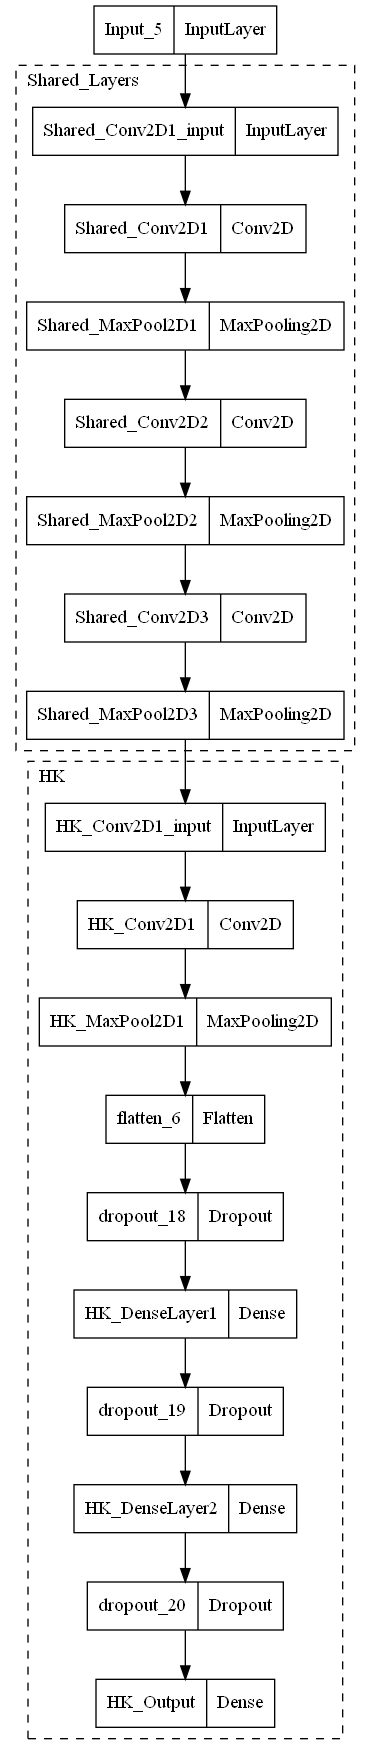

In [43]:
input5 = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='Input_5')

shared5.trainable = False
sharedLayers5 = shared5(input5)
individualLayers5 = languagelayers(NUM_LABELS_HK,'HK')(sharedLayers5)

model5 = tf.keras.Model(
    inputs=[input5],
    outputs=[individualLayers5],
    name='Full_Model_5'
)

model5.summary(expand_nested=True)
tf.keras.utils.plot_model(model5, expand_nested=True)


In [44]:
model5.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)


In [45]:
training_callback5 = callbacks.TensorBoard(log_dir=LOG_DIR + '5')
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint5 = callbacks.ModelCheckpoint(
    filepath=MODEL_SAVE_PATH + '5',
    save_weights_only=False,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [46]:
history5 = model5.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback5,earlystopping_callback,reduce_lr_callback,checkpoint5],
    verbose=1
)


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 3.1105 - Categorical_Accuracy: 0.0680 - AUC: 0.4897 

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 4s 301ms/step - loss: 3.1105 - Categorical_Accuracy: 0.0680 - AUC: 0.4897 - val_loss: 2.5443 - val_Categorical_Accuracy: 0.1224 - val_AUC: 0.5289 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 2.6052 - Categorical_Accuracy: 0.1240 - AUC: 0.5433

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 282ms/step - loss: 2.6052 - Categorical_Accuracy: 0.1240 - AUC: 0.5433 - val_loss: 2.4369 - val_Categorical_Accuracy: 0.1245 - val_AUC: 0.5960 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 2.5299 - Categorical_Accuracy: 0.0980 - AUC: 0.5529

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 280ms/step - loss: 2.5299 - Categorical_Accuracy: 0.0980 - AUC: 0.5529 - val_loss: 2.3896 - val_Categorical_Accuracy: 0.1857 - val_AUC: 0.6499 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 2.4450 - Categorical_Accuracy: 0.1420 - AUC: 0.5941

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 310ms/step - loss: 2.4450 - Categorical_Accuracy: 0.1420 - AUC: 0.5941 - val_loss: 2.3466 - val_Categorical_Accuracy: 0.2020 - val_AUC: 0.6926 - lr: 1.0000e-04
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 2.3600 - Categorical_Accuracy: 0.1820 - AUC: 0.6480

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 285ms/step - loss: 2.3600 - Categorical_Accuracy: 0.1820 - AUC: 0.6480 - val_loss: 2.3103 - val_Categorical_Accuracy: 0.2061 - val_AUC: 0.7175 - lr: 1.0000e-04
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 2.3461 - Categorical_Accuracy: 0.1840 - AUC: 0.6568

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 276ms/step - loss: 2.3461 - Categorical_Accuracy: 0.1840 - AUC: 0.6568 - val_loss: 2.2675 - val_Categorical_Accuracy: 0.2306 - val_AUC: 0.7375 - lr: 1.0000e-04
Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 2.2818 - Categorical_Accuracy: 0.1960 - AUC: 0.6937

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 313ms/step - loss: 2.2818 - Categorical_Accuracy: 0.1960 - AUC: 0.6937 - val_loss: 2.2145 - val_Categorical_Accuracy: 0.2633 - val_AUC: 0.7765 - lr: 1.0000e-04
Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 2.2226 - Categorical_Accuracy: 0.2340 - AUC: 0.7227

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 278ms/step - loss: 2.2226 - Categorical_Accuracy: 0.2340 - AUC: 0.7227 - val_loss: 2.1643 - val_Categorical_Accuracy: 0.2837 - val_AUC: 0.7930 - lr: 1.0000e-04
Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 2.1362 - Categorical_Accuracy: 0.2780 - AUC: 0.7551

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 279ms/step - loss: 2.1362 - Categorical_Accuracy: 0.2780 - AUC: 0.7551 - val_loss: 2.1101 - val_Categorical_Accuracy: 0.3163 - val_AUC: 0.7965 - lr: 1.0000e-04
Epoch 10/100
 9/10 [==========================>...] - ETA: 0s - loss: 2.1414 - Categorical_Accuracy: 0.2578 - AUC: 0.7541
Epoch 00010: val_loss improved from 2.11009 to 2.06071, saving model to savedcheckpoints5


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 2s 271ms/step - loss: 2.1269 - Categorical_Accuracy: 0.2640 - AUC: 0.7583 - val_loss: 2.0607 - val_Categorical_Accuracy: 0.3184 - val_AUC: 0.8049 - lr: 1.0000e-04
Epoch 11/100
 9/10 [==========================>...] - ETA: 0s - loss: 2.0956 - Categorical_Accuracy: 0.2756 - AUC: 0.7654
Epoch 00011: val_loss improved from 2.06071 to 2.01049, saving model to savedcheckpoints5


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 313ms/step - loss: 2.0801 - Categorical_Accuracy: 0.2900 - AUC: 0.7706 - val_loss: 2.0105 - val_Categorical_Accuracy: 0.3510 - val_AUC: 0.8287 - lr: 1.0000e-04
Epoch 12/100
10/10 [==============================] - ETA: 0s - loss: 2.0262 - Categorical_Accuracy: 0.3020 - AUC: 0.7896

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 282ms/step - loss: 2.0262 - Categorical_Accuracy: 0.3020 - AUC: 0.7896 - val_loss: 1.9659 - val_Categorical_Accuracy: 0.3857 - val_AUC: 0.8364 - lr: 1.0000e-04
Epoch 13/100
10/10 [==============================] - ETA: 0s - loss: 1.9813 - Categorical_Accuracy: 0.3100 - AUC: 0.8084

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 279ms/step - loss: 1.9813 - Categorical_Accuracy: 0.3100 - AUC: 0.8084 - val_loss: 1.9116 - val_Categorical_Accuracy: 0.4102 - val_AUC: 0.8474 - lr: 1.0000e-04
Epoch 14/100
10/10 [==============================] - ETA: 0s - loss: 1.9197 - Categorical_Accuracy: 0.3540 - AUC: 0.8184
Epoch 00014: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 274ms/step - loss: 1.9197 - Categorical_Accuracy: 0.3540 - AUC: 0.8184 - val_loss: 1.8614 - val_Categorical_Accuracy: 0.3980 - val_AUC: 0.8545 - lr: 1.0000e-04
Epoch 15/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.8468 - Categorical_Accuracy: 0.3489 - AUC: 0.8420

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 316ms/step - loss: 1.8498 - Categorical_Accuracy: 0.3500 - AUC: 0.8403 - val_loss: 1.8328 - val_Categorical_Accuracy: 0.4061 - val_AUC: 0.8618 - lr: 1.0000e-04
Epoch 16/100
10/10 [==============================] - ETA: 0s - loss: 1.8105 - Categorical_Accuracy: 0.3720 - AUC: 0.8489
Epoch 00016: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 273ms/step - loss: 1.8105 - Categorical_Accuracy: 0.3720 - AUC: 0.8489 - val_loss: 1.7813 - val_Categorical_Accuracy: 0.4347 - val_AUC: 0.8691 - lr: 1.0000e-04
Epoch 17/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.7239 - Categorical_Accuracy: 0.4222 - AUC: 0.8682
Epoch 00017: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 281ms/step - loss: 1.7046 - Categorical_Accuracy: 0.4260 - AUC: 0.8720 - val_loss: 1.7356 - val_Categorical_Accuracy: 0.4367 - val_AUC: 0.8781 - lr: 1.0000e-04
Epoch 18/100
10/10 [==============================] - ETA: 0s - loss: 1.6891 - Categorical_Accuracy: 0.4360 - AUC: 0.8711

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 275ms/step - loss: 1.6891 - Categorical_Accuracy: 0.4360 - AUC: 0.8711 - val_loss: 1.6917 - val_Categorical_Accuracy: 0.4673 - val_AUC: 0.8844 - lr: 1.0000e-04
Epoch 19/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.6403 - Categorical_Accuracy: 0.4289 - AUC: 0.8856
Epoch 00019: val_loss improved from 1.69169 to 1.65695, saving model to savedcheckpoints5


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 313ms/step - loss: 1.6463 - Categorical_Accuracy: 0.4280 - AUC: 0.8834 - val_loss: 1.6570 - val_Categorical_Accuracy: 0.4857 - val_AUC: 0.8875 - lr: 1.0000e-04
Epoch 20/100
10/10 [==============================] - ETA: 0s - loss: 1.5388 - Categorical_Accuracy: 0.4940 - AUC: 0.9015

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 280ms/step - loss: 1.5388 - Categorical_Accuracy: 0.4940 - AUC: 0.9015 - val_loss: 1.6194 - val_Categorical_Accuracy: 0.4796 - val_AUC: 0.8920 - lr: 1.0000e-04
Epoch 21/100
10/10 [==============================] - ETA: 0s - loss: 1.5123 - Categorical_Accuracy: 0.4820 - AUC: 0.9038

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 275ms/step - loss: 1.5123 - Categorical_Accuracy: 0.4820 - AUC: 0.9038 - val_loss: 1.5810 - val_Categorical_Accuracy: 0.5265 - val_AUC: 0.8967 - lr: 1.0000e-04
Epoch 22/100
10/10 [==============================] - ETA: 0s - loss: 1.4999 - Categorical_Accuracy: 0.4840 - AUC: 0.9074
Epoch 00022: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 281ms/step - loss: 1.4999 - Categorical_Accuracy: 0.4840 - AUC: 0.9074 - val_loss: 1.5378 - val_Categorical_Accuracy: 0.5327 - val_AUC: 0.9036 - lr: 1.0000e-04
Epoch 23/100
10/10 [==============================] - ETA: 0s - loss: 1.4335 - Categorical_Accuracy: 0.5120 - AUC: 0.9140
Epoch 00023: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 314ms/step - loss: 1.4335 - Categorical_Accuracy: 0.5120 - AUC: 0.9140 - val_loss: 1.5095 - val_Categorical_Accuracy: 0.5408 - val_AUC: 0.9052 - lr: 1.0000e-04
Epoch 24/100
10/10 [==============================] - ETA: 0s - loss: 1.3985 - Categorical_Accuracy: 0.4940 - AUC: 0.9205
Epoch 00024: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 273ms/step - loss: 1.3985 - Categorical_Accuracy: 0.4940 - AUC: 0.9205 - val_loss: 1.4767 - val_Categorical_Accuracy: 0.5469 - val_AUC: 0.9087 - lr: 1.0000e-04
Epoch 25/100
10/10 [==============================] - ETA: 0s - loss: 1.3590 - Categorical_Accuracy: 0.5320 - AUC: 0.9248

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 274ms/step - loss: 1.3590 - Categorical_Accuracy: 0.5320 - AUC: 0.9248 - val_loss: 1.4333 - val_Categorical_Accuracy: 0.5592 - val_AUC: 0.9141 - lr: 1.0000e-04
Epoch 26/100
10/10 [==============================] - ETA: 0s - loss: 1.3099 - Categorical_Accuracy: 0.5600 - AUC: 0.9301

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 275ms/step - loss: 1.3099 - Categorical_Accuracy: 0.5600 - AUC: 0.9301 - val_loss: 1.4118 - val_Categorical_Accuracy: 0.5531 - val_AUC: 0.9179 - lr: 1.0000e-04
Epoch 27/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.2203 - Categorical_Accuracy: 0.6200 - AUC: 0.9432
Epoch 00027: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 309ms/step - loss: 1.2301 - Categorical_Accuracy: 0.6140 - AUC: 0.9416 - val_loss: 1.3760 - val_Categorical_Accuracy: 0.5857 - val_AUC: 0.9222 - lr: 1.0000e-04
Epoch 28/100
10/10 [==============================] - ETA: 0s - loss: 1.1962 - Categorical_Accuracy: 0.6440 - AUC: 0.9456

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 274ms/step - loss: 1.1962 - Categorical_Accuracy: 0.6440 - AUC: 0.9456 - val_loss: 1.3456 - val_Categorical_Accuracy: 0.5837 - val_AUC: 0.9240 - lr: 1.0000e-04
Epoch 29/100
10/10 [==============================] - ETA: 0s - loss: 1.1516 - Categorical_Accuracy: 0.6040 - AUC: 0.9469
Epoch 00029: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 275ms/step - loss: 1.1516 - Categorical_Accuracy: 0.6040 - AUC: 0.9469 - val_loss: 1.3096 - val_Categorical_Accuracy: 0.5837 - val_AUC: 0.9272 - lr: 1.0000e-04
Epoch 30/100
10/10 [==============================] - ETA: 0s - loss: 1.1009 - Categorical_Accuracy: 0.6400 - AUC: 0.9543

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 274ms/step - loss: 1.1009 - Categorical_Accuracy: 0.6400 - AUC: 0.9543 - val_loss: 1.2926 - val_Categorical_Accuracy: 0.5959 - val_AUC: 0.9292 - lr: 1.0000e-04
Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 1.0936 - Categorical_Accuracy: 0.6080 - AUC: 0.9546
Epoch 00031: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 310ms/step - loss: 1.0936 - Categorical_Accuracy: 0.6080 - AUC: 0.9546 - val_loss: 1.2760 - val_Categorical_Accuracy: 0.5776 - val_AUC: 0.9313 - lr: 1.0000e-04
Epoch 32/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.0921 - Categorical_Accuracy: 0.6244 - AUC: 0.9540
Epoch 00032: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 276ms/step - loss: 1.0837 - Categorical_Accuracy: 0.6280 - AUC: 0.9550 - val_loss: 1.2675 - val_Categorical_Accuracy: 0.6163 - val_AUC: 0.9308 - lr: 1.0000e-04
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 1.0361 - Categorical_Accuracy: 0.6620 - AUC: 0.9596

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 286ms/step - loss: 1.0361 - Categorical_Accuracy: 0.6620 - AUC: 0.9596 - val_loss: 1.2594 - val_Categorical_Accuracy: 0.5837 - val_AUC: 0.9310 - lr: 1.0000e-04
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.9945 - Categorical_Accuracy: 0.6760 - AUC: 0.9621

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 321ms/step - loss: 0.9945 - Categorical_Accuracy: 0.6760 - AUC: 0.9621 - val_loss: 1.2310 - val_Categorical_Accuracy: 0.6122 - val_AUC: 0.9350 - lr: 1.0000e-04
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.9524 - Categorical_Accuracy: 0.6780 - AUC: 0.9669
Epoch 00035: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 278ms/step - loss: 0.9524 - Categorical_Accuracy: 0.6780 - AUC: 0.9669 - val_loss: 1.1955 - val_Categorical_Accuracy: 0.6041 - val_AUC: 0.9385 - lr: 1.0000e-04
Epoch 36/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.8818 - Categorical_Accuracy: 0.7289 - AUC: 0.9716
Epoch 00036: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 273ms/step - loss: 0.9097 - Categorical_Accuracy: 0.7100 - AUC: 0.9694 - val_loss: 1.1665 - val_Categorical_Accuracy: 0.6306 - val_AUC: 0.9412 - lr: 1.0000e-04
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.9254 - Categorical_Accuracy: 0.7180 - AUC: 0.9663

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 278ms/step - loss: 0.9254 - Categorical_Accuracy: 0.7180 - AUC: 0.9663 - val_loss: 1.1575 - val_Categorical_Accuracy: 0.6367 - val_AUC: 0.9413 - lr: 1.0000e-04
Epoch 38/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.8324 - Categorical_Accuracy: 0.7467 - AUC: 0.9755
Epoch 00038: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 309ms/step - loss: 0.8475 - Categorical_Accuracy: 0.7460 - AUC: 0.9733 - val_loss: 1.1394 - val_Categorical_Accuracy: 0.6265 - val_AUC: 0.9437 - lr: 1.0000e-04
Epoch 39/100
10/10 [==============================] - ETA: 0s - loss: 0.8070 - Categorical_Accuracy: 0.7540 - AUC: 0.9768
Epoch 00039: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 275ms/step - loss: 0.8070 - Categorical_Accuracy: 0.7540 - AUC: 0.9768 - val_loss: 1.1296 - val_Categorical_Accuracy: 0.6265 - val_AUC: 0.9430 - lr: 1.0000e-04
Epoch 40/100
10/10 [==============================] - ETA: 0s - loss: 0.8419 - Categorical_Accuracy: 0.7260 - AUC: 0.9728

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 276ms/step - loss: 0.8419 - Categorical_Accuracy: 0.7260 - AUC: 0.9728 - val_loss: 1.1239 - val_Categorical_Accuracy: 0.6082 - val_AUC: 0.9447 - lr: 1.0000e-04
Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 0.7839 - Categorical_Accuracy: 0.7380 - AUC: 0.9782
Epoch 00041: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 273ms/step - loss: 0.7839 - Categorical_Accuracy: 0.7380 - AUC: 0.9782 - val_loss: 1.1030 - val_Categorical_Accuracy: 0.6469 - val_AUC: 0.9458 - lr: 1.0000e-04
Epoch 42/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7452 - Categorical_Accuracy: 0.7644 - AUC: 0.9798
Epoch 00042: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 313ms/step - loss: 0.7442 - Categorical_Accuracy: 0.7640 - AUC: 0.9799 - val_loss: 1.1009 - val_Categorical_Accuracy: 0.6265 - val_AUC: 0.9464 - lr: 1.0000e-04
Epoch 43/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7612 - Categorical_Accuracy: 0.7511 - AUC: 0.9775
Epoch 00043: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 290ms/step - loss: 0.7698 - Categorical_Accuracy: 0.7440 - AUC: 0.9771 - val_loss: 1.0850 - val_Categorical_Accuracy: 0.6429 - val_AUC: 0.9469 - lr: 1.0000e-04
Epoch 44/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7126 - Categorical_Accuracy: 0.7844 - AUC: 0.9819

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 276ms/step - loss: 0.7067 - Categorical_Accuracy: 0.7860 - AUC: 0.9820 - val_loss: 1.0785 - val_Categorical_Accuracy: 0.6163 - val_AUC: 0.9480 - lr: 1.0000e-04
Epoch 45/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7029 - Categorical_Accuracy: 0.7711 - AUC: 0.9823
Epoch 00045: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 276ms/step - loss: 0.7049 - Categorical_Accuracy: 0.7700 - AUC: 0.9822 - val_loss: 1.0736 - val_Categorical_Accuracy: 0.6327 - val_AUC: 0.9488 - lr: 1.0000e-04
Epoch 46/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7387 - Categorical_Accuracy: 0.7733 - AUC: 0.9775

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 311ms/step - loss: 0.7154 - Categorical_Accuracy: 0.7840 - AUC: 0.9793 - val_loss: 1.0659 - val_Categorical_Accuracy: 0.6551 - val_AUC: 0.9488 - lr: 1.0000e-04
Epoch 47/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7115 - Categorical_Accuracy: 0.7578 - AUC: 0.9799
Epoch 00047: val_loss did 

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 270ms/step - loss: 0.6549 - Categorical_Accuracy: 0.8040 - AUC: 0.9844 - val_loss: 1.0459 - val_Categorical_Accuracy: 0.6612 - val_AUC: 0.9504 - lr: 1.0000e-04
Epoch 49/100
10/10 [==============================] - ETA: 0s - loss: 0.5833 - Categorical_Accuracy: 0.8420 - AUC: 0.9894

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 275ms/step - loss: 0.5833 - Categorical_Accuracy: 0.8420 - AUC: 0.9894 - val_loss: 1.0376 - val_Categorical_Accuracy: 0.6510 - val_AUC: 0.9501 - lr: 1.0000e-04
Epoch 50/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.5859 - Categorical_Accuracy: 0.8356 - AUC: 0.9875

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 273ms/step - loss: 0.5901 - Categorical_Accuracy: 0.8320 - AUC: 0.9874 - val_loss: 1.0298 - val_Categorical_Accuracy: 0.6490 - val_AUC: 0.9508 - lr: 1.0000e-04
Epoch 51/100
10/10 [==============================] - ETA: 0s - loss: 0.6277 - Categorical_Accuracy: 0.8040 - AUC: 0.9849

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 312ms/step - loss: 0.6277 - Categorical_Accuracy: 0.8040 - AUC: 0.9849 - val_loss: 1.0223 - val_Categorical_Accuracy: 0.6469 - val_AUC: 0.9511 - lr: 1.0000e-04
Epoch 52/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.6034 - Categorical_Accuracy: 0.8133 - AUC: 0.9853

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 274ms/step - loss: 0.5980 - Categorical_Accuracy: 0.8180 - AUC: 0.9858 - val_loss: 1.0196 - val_Categorical_Accuracy: 0.6449 - val_AUC: 0.9516 - lr: 1.0000e-04
Epoch 53/100
10/10 [==============================] - ETA: 0s - loss: 0.5484 - Categorical_Accuracy: 0.8240 - AUC: 0.9900

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 2s 270ms/step - loss: 0.5484 - Categorical_Accuracy: 0.8240 - AUC: 0.9900 - val_loss: 1.0187 - val_Categorical_Accuracy: 0.6408 - val_AUC: 0.9519 - lr: 1.0000e-04
Epoch 54/100
10/10 [==============================] - ETA: 0s - loss: 0.5216 - Categorical_Accuracy: 0.8420 - AUC: 0.9910

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 271ms/step - loss: 0.5216 - Categorical_Accuracy: 0.8420 - AUC: 0.9910 - val_loss: 1.0010 - val_Categorical_Accuracy: 0.6673 - val_AUC: 0.9528 - lr: 1.0000e-04
Epoch 55/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.5141 - Categorical_Accuracy: 0.8356 - AUC: 0.9908
Epoch 00055: val_loss did 

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 306ms/step - loss: 0.5017 - Categorical_Accuracy: 0.8460 - AUC: 0.9907 - val_loss: 0.9968 - val_Categorical_Accuracy: 0.6612 - val_AUC: 0.9543 - lr: 1.0000e-04
Epoch 57/100
10/10 [==============================] - ETA: 0s - loss: 0.4917 - Categorical_Accuracy: 0.8660 - AUC: 0.9911

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 2s 269ms/step - loss: 0.4917 - Categorical_Accuracy: 0.8660 - AUC: 0.9911 - val_loss: 0.9854 - val_Categorical_Accuracy: 0.6592 - val_AUC: 0.9547 - lr: 1.0000e-04
Epoch 58/100
10/10 [==============================] - ETA: 0s - loss: 0.4363 - Categorical_Accuracy: 0.8660 - AUC: 0.9934

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 2s 267ms/step - loss: 0.4363 - Categorical_Accuracy: 0.8660 - AUC: 0.9934 - val_loss: 0.9827 - val_Categorical_Accuracy: 0.6571 - val_AUC: 0.9543 - lr: 1.0000e-04
Epoch 59/100
10/10 [==============================] - ETA: 0s - loss: 0.4442 - Categorical_Accuracy: 0.8860 - AUC: 0.9941
Epoch 00059: val_loss impr

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 2s 265ms/step - loss: 0.4442 - Categorical_Accuracy: 0.8860 - AUC: 0.9941 - val_loss: 0.9792 - val_Categorical_Accuracy: 0.6571 - val_AUC: 0.9554 - lr: 1.0000e-04
Epoch 60/100
10/10 [==============================] - ETA: 0s - loss: 0.4661 - Categorical_Accuracy: 0.8500 - AUC: 0.9920

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


10/10 [==============================] - 3s 306ms/step - loss: 0.4661 - Categorical_Accuracy: 0.8500 - AUC: 0.9920 - val_loss: 0.9661 - val_Categorical_Accuracy: 0.6612 - val_AUC: 0.9559 - lr: 1.0000e-04
Epoch 61/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.4302 - Categorical_Accuracy: 0.8756 - AUC: 0.9939
Epoch 00061: val_loss did 

In [47]:
model5c = keras.models.load_model('savedcheckpoints5')
model5c.evaluate(testdatasetHK)

250/250 [==============================] - 2s 6ms/step - loss: 1.1191 - Categorical_Accuracy: 0.6360 - AUC: 0.9379

[1.119125485420227, 0.6359999775886536, 0.9379476308822632]